# Final Project Notebook

DS 5001 Exploratory Text Analytics | Spring 2024

In [256]:
# import libraries

import configparser
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import sys
import re
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA
import plotly_express as px
from IPython.display import display, HTML
from gensim.models import word2vec
from sklearn.manifold import TSNE
import gensim
from gensim.corpora import Dictionary

In [257]:
# set up config

config = configparser.ConfigParser()
config.read("../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

sys.path.append(local_lib)

In [258]:
# set sorce file path

source_files = f'{data_home}/wonderland-set'
data_prefix = 'wonderland'

In [259]:
# set up OHCO

OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [260]:
# load in parser

from textparser import TextParser

In [261]:
# # define chunk pattern

clip_pats = [
    r"\*\*\*\s*START OF",
    r"\*\*\*\s*END OF"
]

# All are 'chap'and 'm'
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
ohco_pat_list = [
    (1,   rf"(?i)^\s*CHAPTER\s+{roman}\.?\s*$"),
    (2,   rf"(?i)^\s*Fit\s(the\s)?[A-Z][a-z]+\s.*"),
    (3,   rf"(?i)^\s*CHAPTER\s+{roman}\.?\s*$"),
    (4,   rf"(?i)^\s*CHAPTER \d+\.\s*(.*)$"),
    (5,   rf"(?i)^\s*Knot\s+{roman}\.?\s*$"),
    (6,   rf"(?i)^\s*{roman}\.?\s*$"), 
    (7,   rf"(?i)^\s*CHAPTER\s+{roman}\.?\s*$"),
    (8,   rf"(?i)^\s*CHAPTER\s+[IVXLCDM]+\s*$"),
    (9,   rf"(?i)^\s*CHAPTER\s+{roman}\.?\s*$"), 
    (10,  rf"(?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$"),
]

In [262]:
# intial text cleaning

# 1: illustrations and ints (done)
# 3: ints (done)
# 5: [int] (done)
# 8: [int]

def delete(file_path, word):

    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    #modified_content = content.replace(word, '')
    #modified_content = re.sub(r'\d+', '', content)
    #modified_content = re.sub(r'\[\d+\]', '', content)
    #modified_content = re.sub(r'\{[^}]*\}', '', content)
    modified_content = content.replace(word, '')

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(modified_content)
        file.close()     

In [122]:
#delete("C:\\Users\\Owner\\DS5001\\Data\\wonderland-set\\alice_in_wonderland-1.txt", '*')

In [263]:
# Add each file to LIB

source_file_list = sorted(glob(f"{source_files}/*.*"))

In [264]:
# Getting book data

book_data = []
for source_file_path in source_file_list:
    #print(source_file_path)
    book_id = int(source_file_path.split('-')[-1].split('.')[0])
    book_title = source_file_path.split('\\')[1].split('-')[0]
    book_data.append((book_id, source_file_path, book_title))

In [247]:
# add popularity (bad: [, 3.4), mid: [3.4, 4), good: [4,]) to LIB

# source: https://www.goodreads.com/author/list/8164.Lewis_Carroll 
# goodread's popularity:
# 1. Alice in Wonderland (good)
# 2. Hunting of the snark (good)
# 3. Slvie and Bruno pt 2 (mid)
# 4. Slvie and Bruno (bad)
# 5. Tangled tales (bad)
# 6. The nursery (mid)
# 7. Through the looking glass (good)
# 8. Crime and Punishment (good)
# 9. The Brothers Karamazov (good)
# 10. The Devils (good)

# add book era to lib (early: 60's, middle: 70's - mid 80's, late: late 80's - 90's)
# add dos book era to lib (early: 40's, middle: 60's, late: 70's)

# books publication dates:

# 1. Alice in Wonderland 1865 (early)
# 2. Hunting of the snark 1876 (mid)
# 3. Slvie and Bruno pt 2 1893 (late)
# 4. Slvie and Bruno 1889 (late)
# 5. Tangled tales 1880-1885 (mid)
# 6. The nursery 1890 (late)
# 7. Through the Looking Glass 1865 (early)
# 8. Crime and Punishment 1866 (middle)
# 9. The Brothers Karamazov (late) 
# 10. The devils (late)

In [265]:
# Creating LIB

LIB = pd.DataFrame(book_data, columns=['book_id','source_file_path','raw_title'])\
    .set_index('book_id').sort_index()
LIB['popularity'] = ['good', 'good', 'mid', 'bad', 'bad', 'mid', 'good', 'good', 'good', 'good']
LIB['era'] = ['early', 'middle', 'late', 'late', 'middle', 'late', 'early', 'middle', 'late', 'late']
LIB['author_id'] = ['carr', 'carr', 'carr', 'carr', 'carr', 'carr', 'carr', 'dos', 'dos', 'dos']

In [266]:
LIB

,source_file_path,raw_title,popularity,era,author_id
book_id,,,,,
1,/Users/Owner/DS5001/Data/wonderland-set\alice_...,alice_in_wonderland,good,early,carr
2,/Users/Owner/DS5001/Data/wonderland-set\huntin...,hunting_of_the_snark,good,middle,carr
3,/Users/Owner/DS5001/Data/wonderland-set\slyvie...,slyvie_and_bruno_pt2,mid,late,carr
4,/Users/Owner/DS5001/Data/wonderland-set\sylvie...,sylvie_and_bruno,bad,late,carr
5,/Users/Owner/DS5001/Data/wonderland-set\tangle...,tangled_tales,bad,middle,carr
6,/Users/Owner/DS5001/Data/wonderland-set\the_nu...,the_nusery,mid,late,carr
7,/Users/Owner/DS5001/Data/wonderland-set\throug...,through_the_looking_glass,good,early,carr
8,/Users/Owner/DS5001/Data/wonderland-set\crime_...,crime_and_punishment,good,middle,dos
9,/Users/Owner/DS5001/Data/wonderland-set\the_br...,the_brothers_karamazov,good,late,dos


In [267]:
# Split raw_title

try:
    LIB['title'] = LIB.raw_title.apply(lambda x: x.upper().replace('_', ' '))
    LIB = LIB.drop('raw_title', axis=1)
except AttributeError:
    pass

In [268]:
LIB

,source_file_path,popularity,era,author_id,title
book_id,,,,,
1,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND
2,/Users/Owner/DS5001/Data/wonderland-set\huntin...,good,middle,carr,HUNTING OF THE SNARK
3,/Users/Owner/DS5001/Data/wonderland-set\slyvie...,mid,late,carr,SLYVIE AND BRUNO PT2
4,/Users/Owner/DS5001/Data/wonderland-set\sylvie...,bad,late,carr,SYLVIE AND BRUNO
5,/Users/Owner/DS5001/Data/wonderland-set\tangle...,bad,middle,carr,TANGLED TALES
6,/Users/Owner/DS5001/Data/wonderland-set\the_nu...,mid,late,carr,THE NUSERY
7,/Users/Owner/DS5001/Data/wonderland-set\throug...,good,early,carr,THROUGH THE LOOKING GLASS
8,/Users/Owner/DS5001/Data/wonderland-set\crime_...,good,middle,dos,CRIME AND PUNISHMENT
9,/Users/Owner/DS5001/Data/wonderland-set\the_br...,good,late,dos,THE BROTHERS KARAMAZOV


In [269]:
# save chapter regex

LIB['chap_regex'] = LIB.index.map(pd.Series({x[0]:x[1] for x in ohco_pat_list}))
LIB

,source_file_path,popularity,era,author_id,title,chap_regex
book_id,,,,,,
1,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$
2,/Users/Owner/DS5001/Data/wonderland-set\huntin...,good,middle,carr,HUNTING OF THE SNARK,(?i)^\s*Fit\s(the\s)?[A-Z][a-z]+\s.*
3,/Users/Owner/DS5001/Data/wonderland-set\slyvie...,mid,late,carr,SLYVIE AND BRUNO PT2,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$
4,/Users/Owner/DS5001/Data/wonderland-set\sylvie...,bad,late,carr,SYLVIE AND BRUNO,(?i)^\s*CHAPTER \d+\.\s*(.*)$
5,/Users/Owner/DS5001/Data/wonderland-set\tangle...,bad,middle,carr,TANGLED TALES,(?i)^\s*Knot\s+[IVXLCM]+\.?\s*$
6,/Users/Owner/DS5001/Data/wonderland-set\the_nu...,mid,late,carr,THE NUSERY,(?i)^\s*[IVXLCM]+\.?\s*$
7,/Users/Owner/DS5001/Data/wonderland-set\throug...,good,early,carr,THROUGH THE LOOKING GLASS,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$
8,/Users/Owner/DS5001/Data/wonderland-set\crime_...,good,middle,dos,CRIME AND PUNISHMENT,(?i)^\s*CHAPTER\s+[IVXLCDM]+\s*$
9,/Users/Owner/DS5001/Data/wonderland-set\the_br...,good,late,dos,THE BROTHERS KARAMAZOV,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$


### Tokenize

In [270]:
# set up textparser

class TextParser():
    """
    A class to parse a single Gutenberg-type text file into a TOKENS dataframe with
    an OHCO index. Also has methods to extract a VOCAB table, although vocabulary
    tables ought to be generated at the corpus level.
    
    Sample parameter values:

    ohco_pats = [
        ('chapter', r"^\s*(chapter|letter)\s+(\d+)", 'm')    
    ]

    clip_pats = [
        r'START OF GUTENBERG PROJECT', 
        r'^\s*THE END'
    ]

    """

    # TODO: Make these private
    src_imported:bool = False       
    src_clipped:bool = False
    src_col_suffix:str ='_str'

    join_pat:str = r'\n'
    strip_hyphens:bool = False
    strip_whitespace:bool = False
    verbose:bool = False

    stanford_pos_model:str = "english-bidirectional-distsim.tagger"
    stanford_pos_model_path = None
        
    # We assume all OHCOs have sentences and tokens
    # and that there are terminal in the list.
    ohco_pats:[] = [
        ('para', r"\n\n", 'd'),
        ('sent', r"[.?!;:]+", 'd'),
        ('token', r"[\s',-]+", 'd')
    ]
        
    _ohco_type:{} = {
        'd': '_num',
        'm': '_id'
    }
        
    def __init__(self, src_file:str, ohco_pats:[], clip_pats:[], use_nltk=True):
        """Initialize the object and extract config info. If using NLTK, download resources."""
        self.src_file = src_file            
        self.clip_pats = clip_pats # TODO: Validate
        self.ohco_pats = ohco_pats + self.ohco_pats # TODO: Validate
        self.OHCO = [item[0]+self._ohco_type[item[2]] for item in self.ohco_pats]
        self.ohco_names = [item[0] for item in self.ohco_pats]
        self.use_nltk = use_nltk

        if self.use_nltk:
            # Override the last two OHCO items
            self.ohco_pats[-2] = ('sent', None, 'nltk')
            self.ohco_pats[-1] = ('token', None, 'nltk')
            # Make sure you have the NLTK stuff
            for package in [
                'tokenizers/punkt', 
                'taggers/averaged_perceptron_tagger', 
                'corpora/stopwords', 
                'help/tagsets'
            ]:
                if self.verbose: print("Checking", package)
                try:
                    nltk.data.find(package)
                except IndexError:
                    nltk.download(package)
            
    def import_source(self, strip:bool=True, char_encoding:str="utf-8-sig"):
        """Convert a raw text file into a dataframe of lines."""
        if self.verbose: print("Importing ", self.src_file)
        text_lines = open(self.src_file,'r', encoding=char_encoding).readlines()
        self.LINES = pd.DataFrame({'line_str':text_lines})
        self.LINES.index.name = 'line_id'
        if strip:
            self.LINES.line_str = self.LINES.line_str.str.strip()
        self.src_imported = True
        if self.verbose: print("Clipping text")
        self._clip_lines()
        return self        

    def _clip_lines(self):
        """Remove cruft lines from beginning and/or end of file."""
        start_pat = self.clip_pats[0]
        end_pat = self.clip_pats[1]
        start = self.LINES.line_str.str.contains(start_pat, regex=True)
        end = self.LINES.line_str.str.contains(end_pat, regex=True)
        try:
            start_line_num = self.LINES.loc[start].index[0]
        except IndexError:
            raise ValueError("Clip start pattern not found.")            
        try:
            end_line_num = self.LINES.loc[end].index[0]
        except IndexError:
            raise ValueError("Clip end pattern not found.")
        self.LINES = self.LINES.loc[start_line_num + 1 : end_line_num - 2]
        self.src_clipped == True
        
    def parse_tokens(self):
        """Convert lines to tokens based on OHCO."""
        if self.src_imported:

            # Start with the LINES df
            self.TOKENS = self.LINES.copy()

            # Walk through each level of the OHCO to build out TOKENS
            for i, level in enumerate(self.OHCO):

                if self.verbose: print(f"Parsing OHCO level {i} {level}", end=' ')

                # Define level-specific variables
                parse_type = self.ohco_pats[i][2]
                div_name = self.ohco_pats[i][0]
                div_pat = self.ohco_pats[i][1]
                if i == 0:
                    src_div_name = 'line'
                else:
                    src_div_name = self.ohco_names[i - 1] 
                src_col = f"{src_div_name}{self.src_col_suffix}"
                dst_col = f"{div_name}{self.src_col_suffix}"

                # By Milestone
                if parse_type == 'm':
                    if self.verbose: print(f"by milestone {div_pat}")
                    div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True) # TODO: Parametize case
                    self.TOKENS.loc[div_lines, div_name] = [i+1 for i in range(self.TOKENS.loc[div_lines].shape[0])]
                    self.TOKENS[div_name] = self.TOKENS[div_name].ffill()
                    self.TOKENS = self.TOKENS.loc[~self.TOKENS[div_name].isna()] 
                    self.TOKENS = self.TOKENS.loc[~div_lines] 
                    self.TOKENS[div_name] = self.TOKENS[div_name].astype('int')
                    self.TOKENS = self.TOKENS.groupby(self.ohco_names[:i+1], group_keys=True)[src_col]\
                        .apply(lambda x: '\n'.join(x)).to_frame(dst_col)

                    # print(self.TOKENS[dst_col].str.count(r'\n\n'))
                    print(src_col, dst_col)
                    print(self.TOKENS)


                # By Delimitter
                elif parse_type == 'd':
                    if self.verbose: print(f"by delimitter {div_pat}")
                    self.TOKENS[src_col] = self.TOKENS[src_col].astype("string")
                    self.TOKENS = self.TOKENS[src_col].str.split(div_pat, expand=True).stack().to_frame(dst_col)
                
                # By NLTK 
                elif parse_type == 'nltk':
                    if self.verbose: print(f"by NLTK model")

                    if level == 'sent_num':
                        self.TOKENS = self.TOKENS.para_str\
                                .apply(lambda x: pd.Series(nltk.sent_tokenize(x), dtype='str'))\
                                .stack()\
                                .to_frame('sent_str')

                    
                    if level == 'token_num':
                        if self.strip_hyphens == True:
                            self.TOKENS.sent_str = self.TOKENS.sent_str.str.replace(r"-", ' ')
                        if self.strip_whitespace == True:
                            self.TOKENS = self.TOKENS.sent_str\
                                    .apply(lambda x: pd.Series(
                                            nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)),
                                            dtype='object'
                                        )
                                    )
                        else:
                            self.TOKENS = self.TOKENS.sent_str\
                                    .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))
                        self.TOKENS = self.TOKENS.stack().to_frame('pos_tuple')
                        self.TOKENS['pos'] = self.TOKENS.pos_tuple.apply(lambda x: x[1])
                        self.TOKENS['token_str'] = self.TOKENS.pos_tuple.apply(lambda x: x[0])
                        self.TOKENS['term_str'] = self.TOKENS.token_str.str.lower()   
        
                else:
                    raise ValueError(f"Invalid parse option: {parse_type}.")

                # After creating the current OHCO level
                self.TOKENS.index.names = self.OHCO[:i+1]

            # After iterating through the OHCO

            if not self.use_nltk:
                self.TOKENS['term_str'] = self.TOKENS.token_str.str.replace(r'[\W_]+', '', regex=True).str.lower()  
            else:
                punc_pos = ['$', "''", '(', ')', ',', '--', '.', ':', '``']
                self.TOKENS['term_str'] = self.TOKENS[~self.TOKENS.pos.isin(punc_pos)].token_str\
                    .str.replace(r'[\W_]+', '', regex=True).str.lower()  
            
        else:
            raise RuntimeError("Source not imported. Please run .import_source()")

    def extract_vocab(self):
        """This should also be done at the corpus level."""
        self.VOCAB = self.TOKENS.term_str.value_counts().to_frame('n')
        self.VOCAB.index.name = 'term_str'
        self.VOCAB['n_chars'] = self.VOCAB.index.str.len()
        self.VOCAB['p'] = self.VOCAB['n'] / self.VOCAB['n'].sum()
        self.VOCAB['s'] = 1 / self.VOCAB['p']
        self.VOCAB['i'] = np.log2(self.VOCAB['s']) # Same as negative log probability (i.e. log likelihood)
        self.VOCAB['h'] = self.VOCAB['p'] * self.VOCAB['i']
        self.H = self.VOCAB['h'].sum()
        return self

    def annotate_vocab(self):
        """This should be done at the corpus level."""
        # Stopwords
        # Max POS
        # POS variability
        # Porter Stems
        pass

    def extract_pos_data(self):
        # TODO: Create dataframe for POS info, including Penn Treebank info
        pass

    def extract_named_entities(self):
        # TODO: Create dataframe of named entities
        pass

    def gather_tokens(self, level=0, grouping_col='term_str', cat_sep=' '):
        """Gather tokens into strings for arbitrary OHCO level."""
        max_level = len(self.OHCO) - 2 # Can't gather tokens at the token level :)
        if level > max_level:
            raise ValueError(f"Level {level} too high. Try between 0 and {max_level}")
        else:
            level_name = self.OHCO[level].split('_')[0]
            idx = self.TOKENS.index.names[:level+1]
            return self.TOKENS.groupby(idx)[grouping_col].apply(lambda x: x.str.cat(sep=cat_sep))\
                .to_frame(f'{level_name}_str')


if __name__ == '__main__':
    pass

In [271]:
def tokenize_collection(LIB):

    clip_pats = [
        r"\*\*\*\s*START OF",
        r"\*\*\*\s*END OF"
    ]

    books = []
    for book_id in LIB.index:

        # Announce
        print("Tokenizing", book_id, LIB.loc[book_id].title)

        # Define vars
        chap_regex = LIB.loc[book_id].chap_regex
        ohco_pats = [('chap', chap_regex, 'm')]
        src_file_path = LIB.loc[book_id].source_file_path

        # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)

        # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.import_source().parse_tokens();

        # Name things
        text.TOKENS['book_id'] = book_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS

In [272]:
# Check 2

CORPUS = tokenize_collection(LIB)

Tokenizing 1 ALICE IN WONDERLAND
Importing  /Users/Owner/DS5001/Data/wonderland-set\alice_in_wonderland-1.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$
line_str chap_str
                                               chap_str
chap                                                   
1     Down the Rabbit-Hole\n\n\nAlice was beginning ...
2     The Pool of Tears\n\n\n“Curiouser and curiouse...
3     A Caucus-Race and a Long Tale\n\n\nThey were i...
4     The Rabbit Sends in a Little Bill\n\n\nIt was ...
5     Advice from a Caterpillar\n\n\nThe Caterpillar...
6     Pig and Pepper\n\n\nFor a minute or two she st...
7     A Mad Tea-Party\n\n\nThere was a table set out...
8     The Queen’s Croquet-Ground\n\n\nA large rose-t...
9     The Mock Turtle’s Story\n\n\n“You can’t think ...
10    The Lobster Quadrille\n\n\nThe Mock Turtle sig...
11    Who Stole the Tarts?\n\n\nThe King and Queen o...
12    Alice’s Evidence\n\n\n“Here!” cried Alice, qui.

C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



Tokenizing 3 SLYVIE AND BRUNO PT2
Importing  /Users/Owner/DS5001/Data/wonderland-set\slyvie_and_bruno_pt2-3.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$
line_str chap_str
                                               chap_str
chap                                                   
1     BRUNO’S LESSONS.\nDuring the next month or two...
2     LOVE’S CURFEW.\n“Fayfield Junction! Change for...
3     STREAKS OF DAWN.\nNext day proved warm and sun...
4     THE DOG-KING.\n“They shooked hands,” said Brun...
5     MATILDA JANE.\n“Come to me, my little gentlema...
6     WILLIE’S WIFE.\nHe made for the door of the pu...
7     MEIN HERR.\nSo I went on my lonely way, and, o...
8     IN A SHADY PLACE.\nThe ten days glided swiftly...
9     THE FAREWELL-PARTY.\nOn the following day, Art...
10    JABBERING AND JAM.\nWhen the last lady had dis...
11    THE MAN IN THE MOON.\nThe children came willin...
12    FAIRY-MUSIC.\nThe silence that ensued was bro

C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5 TANGLED TALES
Importing  /Users/Owner/DS5001/Data/wonderland-set\tangled_tales-5.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone (?i)^\s*Knot\s+[IVXLCM]+\.?\s*$
line_str chap_str
                                               chap_str
chap                                                   
1     EXCELSIOR.\n"Goblin, lead them up and down."\n...
2     ELIGIBLE APARTMENTS.\n"Straight down the crook...
3     MAD MATHESIS.\n"I waited for the train."\n\n"W...
4     THE DEAD RECKONING.\n"I did dream of money-bag...
5     OUGHTS AND CROSSES.\n"Look here, upon this pic...
6     HER RADIANCY.\n"One piecee thing that my have ...
7     PETTY CASH.\n"Base is the slave that pays."\n\...
8     DE OMNIBUS REBUS.\n"This little pig went to ma...
9     A SERPENT WITH CORNERS.\n"Water, water, every ...
10    CHELSEA BUNS.\n"Yea, buns, and buns, and buns!...
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num 

Parsing OHCO level 3 token_num by NLTK model
Done


In [274]:
# Extract features for LIB

LIB['book_len'] = CORPUS.groupby('book_id').term_str.count()

In [275]:
LIB.sort_values('book_len')

,source_file_path,popularity,era,author_id,title,chap_regex,book_len
book_id,,,,,,,
2,/Users/Owner/DS5001/Data/wonderland-set\huntin...,good,middle,carr,HUNTING OF THE SNARK,(?i)^\s*Fit\s(the\s)?[A-Z][a-z]+\s.*,5035
6,/Users/Owner/DS5001/Data/wonderland-set\the_nu...,mid,late,carr,THE NUSERY,(?i)^\s*[IVXLCM]+\.?\s*$,8342
1,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,26559
5,/Users/Owner/DS5001/Data/wonderland-set\tangle...,bad,middle,carr,TANGLED TALES,(?i)^\s*Knot\s+[IVXLCM]+\.?\s*$,27864
7,/Users/Owner/DS5001/Data/wonderland-set\throug...,good,early,carr,THROUGH THE LOOKING GLASS,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,29462
4,/Users/Owner/DS5001/Data/wonderland-set\sylvie...,bad,late,carr,SYLVIE AND BRUNO,(?i)^\s*CHAPTER \d+\.\s*(.*)$,65692
3,/Users/Owner/DS5001/Data/wonderland-set\slyvie...,mid,late,carr,SLYVIE AND BRUNO PT2,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,71210
8,/Users/Owner/DS5001/Data/wonderland-set\crime_...,good,middle,dos,CRIME AND PUNISHMENT,(?i)^\s*CHAPTER\s+[IVXLCDM]+\s*$,204192
10,/Users/Owner/DS5001/Data/wonderland-set\the_de...,good,late,dos,THE DEVILS,(?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$,255110


In [277]:
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_id']]\
    .drop_duplicates()\
    .groupby('book_id').chap_id.count()

In [278]:
LIB

,source_file_path,popularity,era,author_id,title,chap_regex,book_len,n_chaps
book_id,,,,,,,,
1,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,26559,12
2,/Users/Owner/DS5001/Data/wonderland-set\huntin...,good,middle,carr,HUNTING OF THE SNARK,(?i)^\s*Fit\s(the\s)?[A-Z][a-z]+\s.*,5035,9
3,/Users/Owner/DS5001/Data/wonderland-set\slyvie...,mid,late,carr,SLYVIE AND BRUNO PT2,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,71210,25
4,/Users/Owner/DS5001/Data/wonderland-set\sylvie...,bad,late,carr,SYLVIE AND BRUNO,(?i)^\s*CHAPTER \d+\.\s*(.*)$,65692,26
5,/Users/Owner/DS5001/Data/wonderland-set\tangle...,bad,middle,carr,TANGLED TALES,(?i)^\s*Knot\s+[IVXLCM]+\.?\s*$,27864,10
6,/Users/Owner/DS5001/Data/wonderland-set\the_nu...,mid,late,carr,THE NUSERY,(?i)^\s*[IVXLCM]+\.?\s*$,8342,14
7,/Users/Owner/DS5001/Data/wonderland-set\throug...,good,early,carr,THROUGH THE LOOKING GLASS,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,29462,12
8,/Users/Owner/DS5001/Data/wonderland-set\crime_...,good,middle,dos,CRIME AND PUNISHMENT,(?i)^\s*CHAPTER\s+[IVXLCDM]+\s*$,204192,39
9,/Users/Owner/DS5001/Data/wonderland-set\the_br...,good,late,dos,THE BROTHERS KARAMAZOV,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,349447,96


In [279]:
LIB.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\LIB.csv")

### Vocab

In [280]:
# Extract Vocab

CORPUS[CORPUS.term_str == '']

pos_tuple  pos token_str term_str
book_id chap_id para_num sent_num token_num                                   
1       1       18       0        0            (*, JJ)   JJ         *         
                                  1           (*, NNP)  NNP         *         
                                  2           (*, NNP)  NNP         *         
                                  3           (*, NNP)  NNP         *         
                                  4           (*, NNP)  NNP         *         
...                                                ...  ...       ...      ...
10      16      423      1        0           ("_, NN)   NN        "_         
                477      9        0           ("_, NN)   NN        "_         
                510      1        0           ("_, NN)   NN        "_         
                519      1        0           ("_, NN)   NN        "_         
        17      11       6        28         ((?), VB)   VB       (?)         

[826 rows x 4 columns]

In [281]:
CORPUS = CORPUS[CORPUS.term_str != '']

In [282]:
CORPUS['pos_group'] = CORPUS.pos.str[:2]

In [283]:
CORPUS

pos_tuple  pos  token_str  \
book_id chap_id para_num sent_num token_num                                    
1       1       0        0        0               (Down, IN)   IN       Down   
                                  1                (the, DT)   DT        the   
                                  2            (Rabbit, NNP)  NNP     Rabbit   
                                  3              (Hole, NNP)  NNP       Hole   
                1        0        0             (Alice, NNP)  NNP      Alice   
...                                                      ...  ...        ...   
10      17      48       0        10              (idea, NN)   NN       idea   
                                  11                (of, IN)   IN         of   
                                  12         (insanity., NN)   NN  insanity.   
                49       0        0                (THE, DT)   DT        THE   
                                  1                (END, NN)   NN        END   

                                             term_str pos_group  
book_id chap_id para_num sent_num token_num                      
1       1       0        0        0              down        IN  
                                  1               the        DT  
                                  2            rabbit        NN  
                                  3              hole        NN  
                1        0        0             alice        NN  
...                                               ...       ...  
10      17      48       0        10             idea        NN  
                                  11               of        IN  
                                  12         insanity        NN  
                49       0        0               the        DT  
                                  1               end        NN  

[1042819 rows x 5 columns]

In [284]:
CORPUS.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\CORPUS.csv")

In [285]:
# Vocab table

VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

In [286]:
VOCAB

,n,n_chars,p,i
term_str,,,,
0,10,1,9.596128e-06,16.669116
1,67,1,6.429406e-05,13.924955
10,34,2,3.262683e-05,14.903581
100,9,3,8.636515e-06,16.821119
100000l,1,7,9.596128e-07,19.991044
...,...,...,...,...
étape,3,5,2.878838e-06,18.406082
éternelle,1,9,9.596128e-07,19.991044
êtes,6,4,5.757677e-06,17.406082


In [287]:
# Annotate vocab

VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)

In [288]:
# Compute POS ambiguity

VOCAB['n_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack().count(1)
VOCAB['cat_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))

In [289]:
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [290]:
VOCAB

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos
term_str,,,,,,,,,,
0,10,1,9.596128e-06,16.669116,NN,NN,4,"{CD, JJ, VB, NN}",5,"{NNP, CD, VBN, NN, JJ}"
1,67,1,6.429406e-05,13.924955,CD,CD,6,"{CD, FW, VB, NN, RB, JJ}",7,"{NNP, CD, FW, VB, NN, RB, JJ}"
10,34,2,3.262683e-05,14.903581,CD,CD,3,"{CD, VB, NN}",3,"{CD, VB, NN}"
100,9,3,8.636515e-06,16.821119,CD,CD,3,"{CD, VB, NN}",4,"{CD, VB, NNS, NN}"
100000l,1,7,9.596128e-07,19.991044,CD,CD,1,{CD},1,{CD}
...,...,...,...,...,...,...,...,...,...,...
étape,3,5,2.878838e-06,18.406082,NN,NN,1,{NN},2,"{NNP, NN}"
éternelle,1,9,9.596128e-07,19.991044,NNP,NN,1,{NN},1,{NNP}
êtes,6,4,5.757677e-06,17.406082,NNS,NN,1,{NN},1,{NNS}


In [291]:
# Add stop words

sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [292]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [293]:
VOCAB[VOCAB.stop == 1].sample(10)

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop
term_str,,,,,,,,,,,
there,3423,5,0.003285,8.249999,EX,EX,11,"{CD, WR, IN, VB, NN, EX, RB, JJ, MD, CC, RP}",18,"{NNP, CD, IN, VBN, VB, VBD, WRB, NN, VBG, VBP,...",1
them,2845,4,0.002730,8.516831,PRP,PR,9,"{IN, VB, NN, PR, CC, RB, JJ, PD, RP}",16,"{NNP, IN, PRP, VBN, VB, VBD, NN, VBG, VBP, CC,...",1
own,822,3,0.000789,10.308050,JJ,JJ,6,"{IN, VB, NN, RB, MD, JJ}",10,"{NNP, IN, VB, NN, VBP, RB, JJ, MD, NNS, VBZ}",1
will,2770,4,0.002658,8.555374,MD,MD,7,"{IN, VB, NN, PO, RB, JJ, MD}",12,"{NNP, IN, NNS, VB, VBD, NN, VBP, RB, MD, JJ, P...",1
himself,1502,7,0.001441,9.438375,PRP,PR,7,"{IN, VB, NN, PR, RB, JJ, PD}",14,"{NNP, PRP$, IN, PRP, VBN, VB, VBD, NN, VBP, RB...",1
from,3840,4,0.003685,8.084154,IN,IN,6,"{CD, IN, VB, NN, RB, JJ}",11,"{NNP, CD, IN, VB, VBD, NN, VBP, RB, JJ, NNS, VBZ}",1
too,2020,3,0.001938,9.010905,NN,NN,10,"{IN, VB, NN, PR, PO, CC, RB, JJ, MD, RP}",16,"{NNP, IN, PRP, VB, VBD, NN, VBG, POS, VBP, CC,...",1
y,43,1,0.000041,14.564780,NNP,NN,5,"{VB, NN, PR, CC, JJ}",8,"{NNP, PRP, VB, NN, CC, JJR, JJ, VBZ}",1
more,2142,4,0.002055,8.926302,RBR,RB,9,"{IN, FW, VB, NN, PR, RB, JJ, MD, PD}",18,"{NNP, RBR, IN, PRP, VBN, VB, VBD, FW, NN, VBG,...",1


In [294]:
# Add stems

from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [295]:
VOCAB.sample(10)

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,,
lanes,3,5,0.000003,18.406082,NN,NN,1,{NN},2,"{NNS, NN}",0,lane,lane,lan
bilious,2,7,0.000002,18.991044,NN,NN,2,"{JJ, NN}",2,"{JJ, NN}",0,biliou,bilious,bily
get,948,3,0.000910,10.102301,VB,VB,4,"{JJ, VB, NN, IN}",7,"{NNP, IN, VB, NN, VBP, JJ, NNS}",0,get,get,get
partially,7,9,0.000007,17.183689,RB,RB,1,{RB},1,{RB},0,partial,partial,part
minded,13,6,0.000012,16.290605,VBD,VB,3,"{JJ, VB, NN}",4,"{VBN, JJ, VBD, NN}",0,mind,mind,mind
mebbe,3,5,0.000003,18.406082,VB,NN,2,"{VB, NN}",3,"{NNP, VB, NN}",0,mebb,mebb,meb
fetch,54,5,0.000052,14.236157,VB,VB,2,"{VB, NN}",4,"{NNP, VB, VBP, NN}",0,fetch,fetch,fetch
splashed,3,8,0.000003,18.406082,VBN,VB,1,{VB},2,"{VBN, VBD}",0,splash,splash,splashed
merchants,23,9,0.000022,15.467482,NN,NN,3,"{FW, JJ, NN}",4,"{FW, JJ, NNS, NN}",0,merchant,merchant,merch


In [296]:
VOCAB.columns

Index(['n', 'n_chars', 'p', 'i', 'max_pos', 'max_pos_group', 'n_pos_group',
       'cat_pos_group', 'n_pos', 'cat_pos', 'stop', 'stem_porter',
       'stem_snowball', 'stem_lancaster'],
      dtype='object')

### Vectorize data

In [297]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']

tf_method = 'max'
bag = OHCO[:2]
vocab_filter = 'dfidf'
n_terms = 1000

In [298]:
# bow function

def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [299]:
# tfidf/dfidf function

def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF

### BOW table

In [300]:
bag

['book_id', 'chap_id']

In [301]:
BOW = create_bow(CORPUS, bag)

In [302]:
BOW

n
book_id chap_id term_str    
1       1       a         52
                about      8
                across     2
                actually   1
                advice     1
...                       ..
10      17      your       8
                yourself   1
                youth      1
                yulia      2
                zeal       1

[250288 rows x 1 columns]

In [303]:
BOW.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\BOW.csv")

### TFIDF 

In [304]:
TFIDF, DFIDF = get_tfidf(BOW, tf_method)

In [305]:
TFIDF

term_str           0    1   10  100  100000l  10000l  1000l  108  10z   11  \
book_id chap_id                                                              
1       1        0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   
        2        0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   
        3        0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   
        4        0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   
        5        0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   
...              ...  ...  ...  ...      ...     ...    ...  ...  ...  ...   
10      13       0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   
        14       0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   
        15       0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   
        16       0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   
        17       0.0  0.0  0.0  0.0      0.0     0.0    0.0  0.0  0.0  0.0   

term_str         ...  égal   égalité  élite  étage  étaient  étape  éternelle  \
book_id chap_id  ...                                                            
1       1        ...   0.0  0.000000    0.0    0.0      0.0    0.0        0.0   
        2        ...   0.0  0.000000    0.0    0.0      0.0    0.0        0.0   
        3        ...   0.0  0.000000    0.0    0.0      0.0    0.0        0.0   
        4        ...   0.0  0.000000    0.0    0.0      0.0    0.0        0.0   
        5        ...   0.0  0.000000    0.0    0.0      0.0    0.0        0.0   
...              ...   ...       ...    ...    ...      ...    ...        ...   
10      13       ...   0.0  0.000000    0.0    0.0      0.0    0.0        0.0   
        14       ...   0.0  0.000000    0.0    0.0      0.0    0.0        0.0   
        15       ...   0.0  0.000000    0.0    0.0      0.0    0.0        0.0   
        16       ...   0.0  0.006828    0.0    0.0      0.0    0.0        0.0   
        17       ...   0.0  0.000000    0.0    0.0      0.0    0.0        0.0   

term_str             êtes      être  œcumenical  
book_id chap_id                                  
1       1        0.000000  0.000000         0.0  
        2        0.000000  0.000000         0.0  
        3        0.000000  0.000000         0.0  
        4        0.000000  0.000000         0.0  
        5        0.000000  0.000000         0.0  
...                   ...       ...         ...  
10      13       0.043060  0.000000         0.0  
        14       0.000000  0.000000         0.0  
        15       0.000000  0.000000         0.0  
        16       0.016436  0.005479         0.0  
        17       0.000000  0.000000         0.0  

[260 rows x 24344 columns]

In [306]:
TFIDF.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\TFIDF.csv")

In [52]:
TFIDF2 = TFIDF.reset_index()

In [53]:
BOW2 = BOW.reset_index()

In [54]:
TFIDF2

term_str,book_id,chap_id,0,1,10,100,100000l,10000l,1000l,108,...,égal,égalité,élite,étage,étaient,étape,éternelle,êtes,être,œcumenical
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,10,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.043060,0.000000,0.0
256,10,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
257,10,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
258,10,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.006828,0.0,0.0,0.0,0.0,0.0,0.016436,0.005479,0.0


In [56]:
BOW2

,book_id,chap_id,term_str,n
0,1,1,a,52
1,1,1,about,8
2,1,1,across,2
3,1,1,actually,1
4,1,1,advice,1
...,...,...,...,...
250283,10,17,your,8
250284,10,17,yourself,1
250285,10,17,youth,1
250286,10,17,yulia,2


### Reduce vocab to n significant terms

In [307]:
VOCAB['dfidf'] = DFIDF

In [308]:
# top 20 most significant words

VOCAB.dfidf.sort_values(ascending=False).head(20)

term_str
rushed        137.990910
laugh         137.990910
laughing      137.990910
roubles       137.990910
object        137.990910
youd          137.990910
surprised     137.990910
ground        137.990910
fell          137.990910
friends       137.990910
haste         137.988659
says          137.988659
nonsense      137.988659
soul          137.988659
especially    137.978132
wonder        137.978132
position      137.978132
person        137.978132
carried       137.978132
hair          137.978132
Name: dfidf, dtype: float64

In [309]:
VOCAB['mean_tfidf'] = TFIDF.mean()

In [310]:
VIDX = VOCAB.sort_values(vocab_filter, ascending=False)\
    .head(n_terms).index

### Collapse TFIDF by mean bag

In [311]:
M = TFIDF[VIDX].fillna(0).groupby('book_id').mean()

In [312]:
M

term_str,rushed,object,friends,surprised,ground,laugh,roubles,youd,fell,laughing,...,bent,body,trust,failed,described,goodness,share,eh,thoughtfully,silly
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.000943,0.000000,0.002028,0.007024,0.005343,0.001198,0.000000,0.008762,0.006909,0.001557,...,0.002109,0.002510,0.000000,0.000000,0.000000,0.000000,0.001335,0.000000,0.006134,0.000000
2,0.009982,0.002802,0.012284,0.000000,0.017587,0.000000,0.000000,0.008633,0.012517,0.000000,...,0.000000,0.000000,0.004463,0.000000,0.000000,0.000000,0.069826,0.000000,0.000000,0.000000
3,0.001521,0.003977,0.010221,0.001998,0.006238,0.002462,0.000000,0.000749,0.001759,0.000000,...,0.003153,0.007177,0.000613,0.006794,0.000494,0.000000,0.003574,0.003109,0.009364,0.003982
4,0.002781,0.001821,0.009229,0.001569,0.006027,0.003786,0.000000,0.005163,0.001138,0.003865,...,0.003045,0.001472,0.005812,0.000766,0.000658,0.002720,0.003012,0.000000,0.010125,0.003648
5,0.004567,0.000000,0.004996,0.000000,0.000538,0.005665,0.000000,0.011748,0.001572,0.000000,...,0.000000,0.003195,0.007191,0.002767,0.000000,0.000000,0.000237,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.001316,0.004428,0.000000,0.000000,0.015182,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000549,0.000000,0.003743,0.007726,0.008968,0.007209,0.000000,0.023875,0.007396,0.004094,...,0.001146,0.004920,0.000000,0.001146,0.002199,0.000000,0.000000,0.000000,0.011579,0.000000
8,0.008084,0.008210,0.004857,0.006333,0.004543,0.006053,0.016758,0.004590,0.008008,0.011475,...,0.005431,0.003638,0.005855,0.004092,0.002125,0.006484,0.002121,0.010624,0.003360,0.003698
9,0.006189,0.006572,0.005174,0.005782,0.004551,0.008866,0.016958,0.006639,0.007708,0.010999,...,0.003262,0.003263,0.002991,0.002338,0.006020,0.004178,0.002029,0.005195,0.001528,0.005793


### Normalize

In [313]:
L0 = M.astype('bool').astype('int') # Binary (Pseudo L)
L1 = M.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = M.apply(lambda x: x / norm(x), 1) # Euclidean

In [314]:
L0

term_str,rushed,object,friends,surprised,ground,laugh,roubles,youd,fell,laughing,...,bent,body,trust,failed,described,goodness,share,eh,thoughtfully,silly
book_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,1,1,1,0,1,1,1,...,1,1,0,0,0,0,1,0,1,0
2,1,1,1,0,1,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
3,1,1,1,1,1,1,0,1,1,0,...,1,1,1,1,1,0,1,1,1,1
4,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,0,1,1
5,1,0,1,0,1,1,0,1,1,0,...,0,1,1,1,0,0,1,0,0,0
6,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,1,1,1,1,0,1,1,1,...,1,1,0,1,1,0,0,0,1,0
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [315]:
L1

term_str,rushed,object,friends,surprised,ground,laugh,roubles,youd,fell,laughing,...,bent,body,trust,failed,described,goodness,share,eh,thoughtfully,silly
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.000252,0.000000,0.000541,0.001873,0.001425,0.000319,0.000000,0.002337,0.001843,0.000415,...,0.000562,0.000670,0.000000,0.000000,0.000000,0.000000,0.000356,0.000000,0.001636,0.000000
2,0.002940,0.000825,0.003618,0.000000,0.005180,0.000000,0.000000,0.002543,0.003686,0.000000,...,0.000000,0.000000,0.001314,0.000000,0.000000,0.000000,0.020564,0.000000,0.000000,0.000000
3,0.000312,0.000815,0.002095,0.000409,0.001279,0.000505,0.000000,0.000154,0.000360,0.000000,...,0.000646,0.001471,0.000126,0.001392,0.000101,0.000000,0.000732,0.000637,0.001919,0.000816
4,0.000555,0.000364,0.001842,0.000313,0.001203,0.000756,0.000000,0.001030,0.000227,0.000771,...,0.000608,0.000294,0.001160,0.000153,0.000131,0.000543,0.000601,0.000000,0.002021,0.000728
5,0.001271,0.000000,0.001390,0.000000,0.000150,0.001577,0.000000,0.003270,0.000438,0.000000,...,0.000000,0.000889,0.002002,0.000770,0.000000,0.000000,0.000066,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000330,0.001108,0.000000,0.000000,0.003801,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000137,0.000000,0.000936,0.001932,0.002243,0.001803,0.000000,0.005972,0.001850,0.001024,...,0.000287,0.001231,0.000000,0.000287,0.000550,0.000000,0.000000,0.000000,0.002896,0.000000
8,0.001288,0.001308,0.000774,0.001009,0.000724,0.000964,0.002669,0.000731,0.001276,0.001828,...,0.000865,0.000579,0.000933,0.000652,0.000339,0.001033,0.000338,0.001692,0.000535,0.000589
9,0.000984,0.001045,0.000823,0.000919,0.000724,0.001409,0.002696,0.001056,0.001225,0.001749,...,0.000519,0.000519,0.000476,0.000372,0.000957,0.000664,0.000323,0.000826,0.000243,0.000921


In [316]:
L2

term_str,rushed,object,friends,surprised,ground,laugh,roubles,youd,fell,laughing,...,bent,body,trust,failed,described,goodness,share,eh,thoughtfully,silly
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.005092,0.000000,0.010948,0.037917,0.028844,0.006467,0.000000,0.047300,0.037300,0.008403,...,0.011384,0.013553,0.000000,0.000000,0.000000,0.000000,0.007205,0.000000,0.033115,0.000000
2,0.041997,0.011789,0.051683,0.000000,0.073994,0.000000,0.000000,0.036321,0.052662,0.000000,...,0.000000,0.000000,0.018777,0.000000,0.000000,0.000000,0.293772,0.000000,0.000000,0.000000
3,0.003427,0.008959,0.023025,0.004500,0.014054,0.005547,0.000000,0.001687,0.003962,0.000000,...,0.007103,0.016168,0.001382,0.015306,0.001112,0.000000,0.008050,0.007003,0.021096,0.008971
4,0.005299,0.003470,0.017583,0.002988,0.011483,0.007213,0.000000,0.009836,0.002169,0.007363,...,0.005801,0.002804,0.011072,0.001460,0.001253,0.005182,0.005737,0.000000,0.019289,0.006950
5,0.022909,0.000000,0.025061,0.000000,0.002701,0.028420,0.000000,0.058936,0.007886,0.000000,...,0.000000,0.016028,0.036077,0.013883,0.000000,0.000000,0.001189,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.004291,0.014435,0.000000,0.000000,0.049497,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.002368,0.000000,0.016134,0.033298,0.038653,0.031070,0.000000,0.102905,0.031877,0.017646,...,0.004940,0.021206,0.000000,0.004940,0.009476,0.000000,0.000000,0.000000,0.049908,0.000000
8,0.032934,0.033446,0.019789,0.025801,0.018508,0.024661,0.068271,0.018701,0.032625,0.046750,...,0.022127,0.014820,0.023855,0.016671,0.008659,0.026415,0.008643,0.043281,0.013687,0.015067
9,0.018157,0.019280,0.015180,0.016962,0.013352,0.026009,0.049749,0.019478,0.022612,0.032269,...,0.009569,0.009573,0.008776,0.006859,0.017662,0.012256,0.005953,0.015241,0.004482,0.016994


In [317]:
L2.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\TFIDF_L2.csv")

In [318]:
DTM = BOW.n.unstack(fill_value=0)

In [319]:
DTM

term_str         0  1  10  100  100000l  10000l  1000l  108  10z  11  ...  \
book_id chap_id                                                       ...   
1       1        0  0   0    0        0       0      0    0    0   0  ...   
        2        0  0   0    0        0       0      0    0    0   0  ...   
        3        0  0   0    0        0       0      0    0    0   0  ...   
        4        0  0   0    0        0       0      0    0    0   0  ...   
        5        0  0   0    0        0       0      0    0    0   0  ...   
...             .. ..  ..  ...      ...     ...    ...  ...  ...  ..  ...   
10      13       0  0   0    0        0       0      0    0    0   0  ...   
        14       0  0   0    0        0       0      0    0    0   0  ...   
        15       0  0   0    0        0       0      0    0    0   0  ...   
        16       0  0   0    0        0       0      0    0    0   0  ...   
        17       0  0   0    0        0       0      0    0    0   0  ...   

term_str         égal  égalité  élite  étage  étaient  étape  éternelle  êtes  \
book_id chap_id                                                                 
1       1           0        0      0      0        0      0          0     0   
        2           0        0      0      0        0      0          0     0   
        3           0        0      0      0        0      0          0     0   
        4           0        0      0      0        0      0          0     0   
        5           0        0      0      0        0      0          0     0   
...               ...      ...    ...    ...      ...    ...        ...   ...   
10      13          0        0      0      0        0      0          0     2   
        14          0        0      0      0        0      0          0     0   
        15          0        0      0      0        0      0          0     0   
        16          0        1      0      0        0      0          0     3   
        17          0        0      0      0        0      0          0     0   

term_str         être  œcumenical  
book_id chap_id                    
1       1           0           0  
        2           0           0  
        3           0           0  
        4           0           0  
        5           0           0  
...               ...         ...  
10      13          0           0  
        14          0           0  
        15          0           0  
        16          1           0  
        17          0           0  

[260 rows x 24344 columns]

In [320]:
DTM.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\DTM.csv")

In [321]:
VOCAB['df'] = DTM.astype('bool').sum()

In [322]:
VOCAB.sample(10)

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster,dfidf,mean_tfidf,df
term_str,,,,,,,,,,,,,,,,,
appendix,1,8,9.596128e-07,19.991044,NN,NN,1,{NN},1,{NN},0,appendix,appendix,appendix,8.022368,0.000029,1
visitors,81,8,7.772863e-05,13.651194,NNS,NN,4,"{JJ, VB, NN, IN}",6,"{IN, VB, NN, VBP, JJ, NNS}",0,visitor,visitor,visit,101.257968,0.003721,35
gryphon,60,7,5.757677e-05,14.084154,NNP,NN,1,{NN},1,{NNP},0,gryphon,gryphon,gryphon,28.502199,0.013665,5
wisp,19,4,1.823264e-05,15.743117,NN,NN,1,{NN},2,"{NNP, NN}",0,wisp,wisp,wisp,47.004397,0.002693,10
charged,14,7,1.343458e-05,16.183689,VBD,VB,2,"{VB, JJ}",3,"{VBN, VBD, JJ}",0,charg,charg,charg,56.185065,0.001166,13
vashti,1,6,9.596128e-07,19.991044,NNP,NN,1,{NN},1,{NNP},0,vashti,vashti,vasht,8.022368,0.000103,1
harlequin,1,9,9.596128e-07,19.991044,NNP,NN,1,{NN},1,{NNP},0,harlequin,harlequin,harlequin,8.022368,0.000029,1
yea,6,3,5.757677e-06,17.406082,NN,NN,3,"{JJ, RB, NN}",4,"{NNP, NN, RB, JJ}",0,yea,yea,ye,24.089471,0.000641,4
magazine,22,8,2.111148e-05,15.531613,NN,NN,2,"{JJ, NN}",3,"{NNP, JJ, NN}",0,magazin,magazin,magazin,61.732158,0.001352,15


In [323]:
VOCAB.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\VOCAB.csv")

### PCA

In [324]:
# initalize values

bag = OHCO[:2] # chapter
max_terms = 1000
tf_method = 'max'
global_term_sig = 'dfidf'
n_comps = 10
center_by_mean=False
center_by_variance=False

In [325]:
# define function

def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    # if TFIDF.isna().sum().sum():
    #     print("Filled NA")
    #     TFIDF = TFIDF.fillna(0)
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF

In [326]:
TFIDF[VIDX]

term_str           rushed    object   friends  surprised    ground     laugh  \
book_id chap_id                                                                
1       1        0.000000  0.000000  0.015624   0.015624  0.000000  0.000000   
        2        0.000000  0.000000  0.000000   0.030583  0.000000  0.000000   
        3        0.000000  0.000000  0.000000   0.000000  0.000000  0.014374   
        4        0.011318  0.000000  0.000000   0.011318  0.000000  0.000000   
        5        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   
...                   ...       ...       ...        ...       ...       ...   
10      13       0.019230  0.004807  0.000000   0.009615  0.009615  0.019230   
        14       0.007728  0.003864  0.003864   0.015456  0.007728  0.007728   
        15       0.018872  0.003145  0.003145   0.000000  0.003145  0.006291   
        16       0.012233  0.001223  0.007340   0.007340  0.008563  0.003670   
        17       0.006196  0.006196  0.000000   0.000000  0.006196  0.000000   

term_str          roubles      youd      fell  laughing  ...      bent  \
book_id chap_id                                          ...             
1       1        0.000000  0.000000  0.062496  0.000000  ...  0.000000   
        2        0.000000  0.030583  0.000000  0.000000  ...  0.000000   
        3        0.000000  0.000000  0.000000  0.000000  ...  0.025305   
        4        0.000000  0.011318  0.011318  0.000000  ...  0.000000   
        5        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
...                   ...       ...       ...       ...  ...       ...   
10      13       0.019230  0.004807  0.019230  0.014422  ...  0.000000   
        14       0.000000  0.007728  0.003864  0.000000  ...  0.000000   
        15       0.025162  0.028308  0.031453  0.012581  ...  0.016612   
        16       0.007340  0.006117  0.009787  0.002447  ...  0.006461   
        17       0.006196  0.000000  0.012391  0.000000  ...  0.000000   

term_str             body     trust    failed  described  goodness     share  \
book_id chap_id                                                                
1       1        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   
        2        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   
        3        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   
        4        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   
        5        0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   
...                   ...       ...       ...        ...       ...       ...   
10      13       0.000000  0.000000  0.008463   0.000000  0.000000  0.000000   
        14       0.006802  0.000000  0.000000   0.000000  0.006802  0.013605   
        15       0.000000  0.000000  0.000000   0.005537  0.005537  0.005537   
        16       0.015075  0.002154  0.004307   0.006461  0.004307  0.004307   
        17       0.032722  0.000000  0.000000   0.000000  0.000000  0.010907   

term_str               eh  thoughtfully     silly  
book_id chap_id                                    
1       1        0.000000      0.000000  0.000000  
        2        0.000000      0.000000  0.000000  
        3        0.000000      0.000000  0.000000  
        4        0.000000      0.000000  0.000000  
        5        0.000000      0.025561  0.000000  
...                   ...           ...       ...  
10      13       0.050780      0.000000  0.000000  
        14       0.000000      0.006802  0.006802  
        15       0.011074      0.005537  0.022149  
        16       0.004307      0.006461  0.000000  
        17       0.000000      0.000000  0.000000  

[260 rows x 1000 columns]

In [327]:
LOADINGS, DCM, COMPINF = get_pca(TFIDF[VIDX], 
                                 norm_docs=True, 
                                 norm_level=2, 
                                 center_by_mean=center_by_mean, 
                                 center_by_variance=center_by_variance)

In [328]:
LOADINGS.sort_index()

pc_id,0,1,2,3,4,5,6,7,8,9
term_str,,,,,,,,,,
able,-0.004761,-0.014133,0.012453,-0.008425,0.011239,0.020914,0.007277,0.007222,-0.005273,-0.015680
above,-0.008933,-0.003744,0.013515,-0.013713,-0.001624,0.017091,0.011813,-0.000437,-0.022044,0.003135
absolutely,-0.007649,-0.015648,-0.008213,-0.019694,0.017440,0.012324,0.002522,0.006970,-0.000885,-0.017376
absurd,-0.008717,-0.012520,0.000937,-0.011089,0.005327,0.009723,-0.002858,0.018749,0.011648,0.017534
accept,-0.006919,0.005702,0.015629,-0.019977,0.010349,0.006670,0.011399,0.022562,-0.007955,0.003266
...,...,...,...,...,...,...,...,...,...,...
youre,0.000754,-0.026539,0.000398,0.031959,0.013708,-0.026209,-0.018121,0.012012,-0.076548,0.021944
yours,-0.009243,-0.004180,0.003592,-0.003847,0.022595,0.005103,0.006147,0.002045,-0.007685,-0.011862
yourself,-0.020630,-0.014263,0.016316,-0.035417,0.017417,0.005820,-0.014442,0.027566,-0.049121,0.012436


In [329]:
LOADINGS.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\PCA_Loadings.csv")

In [330]:
DCM

pc_id                   0         1         2         3         4         5  \
book_id chap_id                                                               
1       1        0.007517 -0.169714  0.103475  0.160296  0.034898 -0.046291   
        2       -0.001066 -0.170011  0.125199  0.137489  0.054272 -0.037208   
        3        0.008429 -0.162616  0.096234  0.088434  0.057881 -0.005123   
        4        0.001560 -0.186381  0.100088  0.153414  0.054253 -0.032051   
        5        0.008874 -0.147344  0.103247  0.091479  0.032637  0.026740   
...                   ...       ...       ...       ...       ...       ...   
10      13      -0.152978 -0.295837  0.122724 -0.496963  0.203588 -0.121413   
        14      -0.140138 -0.323530  0.043515 -0.674760  0.128396 -0.390508   
        15      -0.130297 -0.258269  0.137008 -0.298933  0.189216  0.194073   
        16      -0.150224 -0.351189  0.097489 -0.620154  0.166889 -0.234670   
        17      -0.156529 -0.290664  0.079063 -0.553946  0.136774 -0.061807   

pc_id                   6         7         8         9  
book_id chap_id                                          
1       1       -0.057707 -0.023110 -0.247507  0.053276  
        2       -0.036739 -0.004398 -0.226123 -0.023065  
        3       -0.014089  0.033512 -0.153759 -0.070864  
        4       -0.093355 -0.019799 -0.263954  0.045362  
        5        0.007994  0.031446 -0.181747 -0.075999  
...                   ...       ...       ...       ...  
10      13      -0.009360  0.075361 -0.220034  0.013626  
        14       0.009542  0.166858 -0.037623 -0.038088  
        15       0.002712  0.011529 -0.354330  0.020352  
        16       0.030103  0.097631 -0.198700 -0.036413  
        17       0.060959  0.120789 -0.047164 -0.031999  

[260 rows x 10 columns]

In [331]:
DCM.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\PCA_DCM.csv")

In [332]:
COMPINF

,pos,neg,eig_val,exp_var
pc_id,,,,
0,bruno sylvie lady replied song,alyosha ivan mitya pyotr dmitri,0.085613,0.278719
1,alyosha ivan bruno sylvie mitya,pyotr herself sister anyone mr,0.051981,0.169228
2,alyosha ivan alexey mother brother,mitya gentlemen fyodor pavlovitch evidence,0.035756,0.116406
3,white picture red herself curious,pyotr bruno sylvie fyodor pavlovitch,0.029947,0.097496
4,mitya alyosha katerina ivanovna yesterday,fyodor pavlovitch ivan father son,0.024315,0.079158
5,ivan lady murder court money,pyotr alyosha picture red white,0.019339,0.062961
6,alyosha fyodor pavlovitch captain father,ivan katerina ivanovna dmitri fyodorovitch,0.017686,0.057579
7,ivan pyotr gentlemen murder court,ivanovna katerina fyodor pavlovitch crowd,0.015953,0.051936
8,court katerina gentlemen ivanovna murder,mitya ivan fyodor stairs pavlovitch,0.013739,0.044728


In [333]:
COMPINF.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\PCA_Components.csv")

### Create Doc

In [334]:
DOC = pd.DataFrame(index=TFIDF.index).join(LIB)

In [335]:
DOC

source_file_path popularity  \
book_id chap_id                                                                 
1       1        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
        2        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
        3        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
        4        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
        5        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
...                                                            ...        ...   
10      13       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   
        14       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   
        15       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   
        16       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   
        17       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   

                   era author_id                title  \
book_id chap_id                                         
1       1        early      carr  ALICE IN WONDERLAND   
        2        early      carr  ALICE IN WONDERLAND   
        3        early      carr  ALICE IN WONDERLAND   
        4        early      carr  ALICE IN WONDERLAND   
        5        early      carr  ALICE IN WONDERLAND   
...                ...       ...                  ...   
10      13        late       dos           THE DEVILS   
        14        late       dos           THE DEVILS   
        15        late       dos           THE DEVILS   
        16        late       dos           THE DEVILS   
        17        late       dos           THE DEVILS   

                                                     chap_regex  book_len  \
book_id chap_id                                                             
1       1                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
        2                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
        3                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
        4                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
        5                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
...                                                         ...       ...   
10      13       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   
        14       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   
        15       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   
        16       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   
        17       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   

                 n_chaps  
book_id chap_id           
1       1             12  
        2             12  
        3             12  
        4             12  
        5             12  
...                  ...  
10      13            17  
        14            17  
        15            17  
        16            17  
        17            17  

[260 rows x 8 columns]

In [336]:
DOC.reset_index(inplace=True)

In [337]:
DOC['label'] = DOC.apply(lambda x: f"{x.title.title()}", 1)

In [338]:
DOC.set_index(['book_id', 'chap_id'], inplace=True)

In [339]:
DOC

source_file_path popularity  \
book_id chap_id                                                                 
1       1        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
        2        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
        3        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
        4        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
        5        /Users/Owner/DS5001/Data/wonderland-set\alice_...       good   
...                                                            ...        ...   
10      13       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   
        14       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   
        15       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   
        16       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   
        17       /Users/Owner/DS5001/Data/wonderland-set\the_de...       good   

                   era author_id                title  \
book_id chap_id                                         
1       1        early      carr  ALICE IN WONDERLAND   
        2        early      carr  ALICE IN WONDERLAND   
        3        early      carr  ALICE IN WONDERLAND   
        4        early      carr  ALICE IN WONDERLAND   
        5        early      carr  ALICE IN WONDERLAND   
...                ...       ...                  ...   
10      13        late       dos           THE DEVILS   
        14        late       dos           THE DEVILS   
        15        late       dos           THE DEVILS   
        16        late       dos           THE DEVILS   
        17        late       dos           THE DEVILS   

                                                     chap_regex  book_len  \
book_id chap_id                                                             
1       1                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
        2                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
        3                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
        4                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
        5                    (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     26559   
...                                                         ...       ...   
10      13       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   
        14       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   
        15       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   
        16       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   
        17       (?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$    255110   

                 n_chaps                label  
book_id chap_id                                
1       1             12  Alice In Wonderland  
        2             12  Alice In Wonderland  
        3             12  Alice In Wonderland  
        4             12  Alice In Wonderland  
        5             12  Alice In Wonderland  
...                  ...                  ...  
10      13            17           The Devils  
        14            17           The Devils  
        15            17           The Devils  
        16            17           The Devils  
        17            17           The Devils  

[260 rows x 9 columns]

### PCA Visaulization 1

In [340]:
pca_dcm_v1 = px.scatter(DCM, 0, 1, 
           color=DOC.era, 
           hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

pca_dcm_v1

In [341]:
px.scatter(LOADINGS.join(VOCAB).reset_index(), 0, 1, hover_name='term_str', 
           size='df', color='dfidf',
           marginal_x='box', marginal_y='box', height=1000)

### Visualization 2

In [342]:
px.scatter(DCM, 2, 3, 
           color=DOC.era, 
           hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

In [343]:
px.scatter(LOADINGS.reset_index(), 2, 3, hover_name='term_str', 
           size=VOCAB.loc[VIDX].n, 
           color=LOADINGS.join(VOCAB['dfidf']).dfidf,
           marginal_x='box', marginal_y='box', height=1000)

### LDA

In [344]:
LABELS = ['popularity','era', 'author_id']

OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
BOOK = OHCO[:1]
CHAP = OHCO[:2]
PARA = OHCO[:3]
BAG = PARA

In [345]:
import pandas as pd # Put here again in case we copy into a separate file
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

class TopicExplorer:
    
    n_features = 4000
    stopwords = 'english'
    lda_num_topics = 20
    lda_max_iter = 5
    lda_n_top_terms = 5
    
    def __init__(self, tokens_df, lib_df, bag, labels=[]):
        self.TOKENS = tokens_df
        self.LIB = lib_df
        self.bag = bag
        self.labels = labels
        
    def generate_tables(self):
        print("BAG:", self.bag[-1])
        print("LABELS:", self.labels)
        print("Getting DOCS")
        self._get_docs()
        print("Getting TERMS")
        self._get_count_model()
        print("Getting THETA, PHI")
        self._get_topic_model()
        print("Getting TOPICS")
        self._get_topics()
        print('Binding LIB labels to THETA')
        self._bind_labels()
        
        print("Done.")
        return self
        
    def _get_docs(self, pos_remove_pat=r'^NNS?$'):
        self.DOCS = self.TOKENS[self.TOKENS.pos.str.match(pos_remove_pat)]\
            .groupby(self.bag).term_str\
            .apply(lambda x: ' '.join(x))\
            .to_frame()\
            .rename(columns={'term_str':'doc_str'})
        
    def _get_count_model(self):
        self.count_engine = CountVectorizer(max_features=self.n_features, 
                                            stop_words=self.stopwords)
        self.count_model = self.count_engine.fit_transform(self.DOCS.doc_str)
        self.TERMS = self.count_engine.get_feature_names()
        
    def _get_topic_model(self):
        self.lda_engine = LDA(n_components=self.lda_num_topics, 
                              max_iter=self.lda_max_iter, 
                              learning_offset=50., 
                              random_state=0)
        self.THETA = pd.DataFrame(self.lda_engine.fit_transform(self.count_model), 
                                  index=self.DOCS.index)
        self.THETA.columns.name = 'topic_id'
        self.PHI = pd.DataFrame(self.lda_engine.components_, columns=self.TERMS)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
    def _get_topics(self, n_terms=10):
        self.TOPICS = self.PHI.stack().to_frame('weight')\
        .groupby('topic_id')\
        .apply(lambda x: x.weight.sort_values(ascending=False)\
            .head(self.lda_n_top_terms)\
            .reset_index()\
            .drop('topic_id', axis=1)\
            .term_str)
        self.TOPICS['label'] = self.TOPICS[[t for t in range(self.lda_n_top_terms)]]\
            .apply(lambda x: str(x.name)\
                   .zfill(len(str(self.lda_num_topics))) + ' ' + ' '.join(x), axis=1)
        self.TOPICS['doc_weight_mean'] = self.THETA.mean()
        self.topic_cols = [t for t in range(self.lda_num_topics)]
        
    def _bind_labels(self):
        self.LABELS = {}
        self.LABEL_VALUES = {}
        for label in self.labels:
            self.THETA[label] = self.THETA\
                .apply(lambda x: self.LIB.loc[x.name[0], label], axis=1)
            self.LABELS[label] = self.THETA.groupby(label)[self.topic_cols].mean().T  
            self.THETA = self.THETA.drop(label, axis=1) # Don't keep the column
            self.LABELS[label].index.name = 'topic_id'
            self.LABELS[label]['label'] = self.TOPICS['label']
            self.LABEL_VALUES[label] = sorted(list(set(self.LIB[label])))
            
    def show_dominant_label_topic(self, label):
        X = self.LABELS[label][self.LABEL_VALUES[label]].idxmax()
        return X.to_frame('topic_id').topic_id.map(self.TOPICS.label)
            
    def show_label_values(self):
        for label in self.LABEL_VALUES:
            print(label, ": ", self.LABEL_VALUES[label])
        
    def show_topic_bar(self):
        fig_height = self.lda_num_topics / 3
        self.TOPICS.sort_values('doc_weight_sum', ascending=True)\
            .plot.barh(y='doc_weight_sum', x='label', figsize=(5, fig_height));
        
    def show_topic_label_heatmap(self, label):
        return MP.LABELS[label][MP.LABEL_VALUES[label]].style.background_gradient()
        
    def show_label_comparison_plot(self, label, label_value_x, label_value_y):
        px.scatter(self.LABELS[label].reset_index(), label_value_x, label_value_y, 
                   hover_name='label', text='topic_id', width=800, height=600)\
            .update_traces(mode='text').show()        

In [346]:
MP = TopicExplorer(CORPUS, LIB, PARA, LABELS).generate_tables()

BAG: para_num
LABELS: ['popularity', 'era', 'author_id']
Getting DOCS
Getting TERMS
Getting THETA, PHI
Getting TOPICS
Binding LIB labels to THETA
Done.


In [347]:
MC = TopicExplorer(CORPUS, LIB, CHAP, LABELS).generate_tables()

BAG: chap_id
LABELS: ['popularity', 'era', 'author_id']
Getting DOCS
Getting TERMS
Getting THETA, PHI
Getting TOPICS
Binding LIB labels to THETA
Done.


In [348]:
MP.TOPICS['phi_p'] = MP.PHI.T.sum() / MP.PHI.T.sum().sum()
MC.TOPICS['phi_p'] = MC.PHI.T.sum() / MC.PHI.T.sum().sum()

In [349]:
MP.TOPICS['phi_h'] = MP.TOPICS.phi_p * np.log2(1/MP.TOPICS.phi_p)
MC.TOPICS['phi_h'] = MC.TOPICS.phi_p * np.log2(1/MC.TOPICS.phi_p)

In [350]:
MP.TOPICS

term_str,0,1,2,3,4,label,doc_weight_mean,phi_p,phi_h
topic_id,,,,,,,,,
0,face,good,way,things,night,00 face good way things night,0.051335,0.042538,0.193765
1,man,window,thousand,father,roubles,01 man window thousand father roubles,0.045986,0.050638,0.217928
2,life,days,time,case,letter,02 life days time case letter,0.044902,0.048190,0.210837
3,room,face,suddenly,minutes,sofa,03 room face suddenly minutes sofa,0.049500,0.046113,0.204681
4,question,answer,man,father,money,04 question answer man father money,0.040722,0.044121,0.198651
5,eyes,voice,money,man,tea,05 eyes voice money man tea,0.050842,0.047030,0.207416
6,tone,time,surprise,away,water,06 tone time surprise away water,0.048594,0.042001,0.192088
7,years,talk,smile,life,face,07 years talk smile life face,0.044837,0.050065,0.216285
8,man,air,moment,heart,breath,08 man air moment heart breath,0.042675,0.042624,0.194033


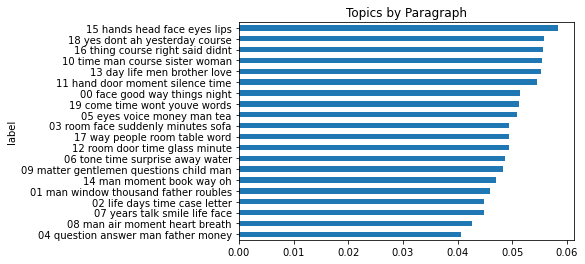

In [351]:
MP.TOPICS.reset_index().set_index('label').doc_weight_mean.sort_values().plot.barh(title="Topics by Paragraph");

In [352]:
MP.TOPICS.reset_index().set_index('label').doc_weight_mean.sort_values(ascending=False)

label
15 hands head face eyes lips               0.058317
18 yes dont ah yesterday course            0.055859
16 thing course right said didnt           0.055692
10 time man course sister woman            0.055527
13 day life men brother love               0.055241
11 hand door moment silence time           0.054482
00 face good way things night              0.051335
19 come time wont youve words              0.051235
05 eyes voice money man tea                0.050842
03 room face suddenly minutes sofa         0.049500
17 way people room table word              0.049489
12 room door time glass minute             0.049364
06 tone time surprise away water           0.048594
09 matter gentlemen questions child man    0.048380
14 man moment book way oh                  0.047021
01 man window thousand father roubles      0.045986
02 life days time case letter              0.044902
07 years talk smile life face              0.044837
08 man air moment heart breath             0.042675
04 que

In [353]:
MC.TOPICS

term_str,0,1,2,3,4,label,doc_weight_mean,phi_p,phi_h
topic_id,,,,,,,,,
0,pocket,dream,watch,fall,thing,00 pocket dream watch fall thing,0.004187,0.001802,0.016429
1,man,money,face,heart,time,01 man money face heart time,0.048452,0.044589,0.200079
2,time,man,way,room,face,02 time man way room face,0.243695,0.352998,0.530298
3,panie,aunt,dear,pipe,sofa,03 panie aunt dear pipe sofa,0.005848,0.003919,0.031334
4,father,money,court,man,time,04 father money court man time,0.038335,0.028696,0.147008
5,man,time,money,yes,moment,05 man time money yes moment,0.119493,0.133090,0.387229
6,time,head,thing,way,things,06 time head thing way things,0.040133,0.019629,0.111312
7,man,time,life,town,years,07 man time life town years,0.047405,0.045423,0.202605
8,man,way,day,life,time,08 man way day life time,0.028377,0.020757,0.116037


In [357]:
MC.TOPICS.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\LDA_TOPIC.csv")

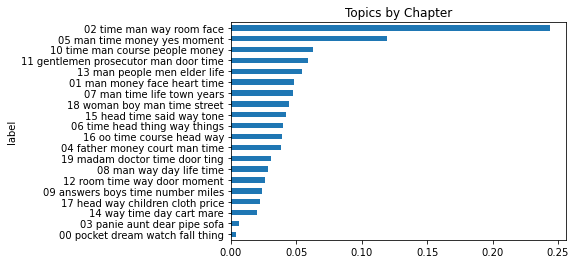

In [358]:
MC.TOPICS.reset_index().set_index('label').doc_weight_mean.sort_values().plot.barh(title="Topics by Chapter");

In [359]:
MC.TOPICS.reset_index().set_index('label').doc_weight_mean.sort_values(ascending=False)

label
02 time man way room face                0.243695
05 man time money yes moment             0.119493
10 time man course people money          0.062605
11 gentlemen prosecutor man door time    0.058841
13 man people men elder life             0.054356
01 man money face heart time             0.048452
07 man time life town years              0.047405
18 woman boy man time street             0.044216
15 head time said way tone               0.041738
06 time head thing way things            0.040133
16 oo time course head way               0.039209
04 father money court man time           0.038335
19 madam doctor time door ting           0.030598
08 man way day life time                 0.028377
12 room time way door moment             0.026377
09 answers boys time number miles        0.023695
17 head way children cloth price         0.022564
14 way time day cart mare                0.019875
03 panie aunt dear pipe sofa             0.005848
00 pocket dream watch fall thing         0.0

### LDA Theta, Phi tables

In [360]:
MP.THETA

topic_id                        0         1         2         3         4   \
book_id chap_id para_num                                                     
1       1       1         0.005000  0.005000  0.005000  0.005000  0.005000   
                2         0.275340  0.005556  0.005556  0.005556  0.005556   
                3         0.952500  0.002500  0.002500  0.002500  0.002500   
                4         0.016667  0.016667  0.016667  0.016667  0.016667   
                5         0.762500  0.012500  0.012500  0.012500  0.012500   
...                            ...       ...       ...       ...       ...   
10      17      45        0.016667  0.016667  0.016667  0.016667  0.016667   
                46        0.008333  0.341667  0.008333  0.008333  0.008333   
                47        0.314954  0.002500  0.166221  0.002500  0.002500   
                48        0.012500  0.012500  0.012500  0.012500  0.012500   
                49        0.025000  0.025000  0.025000  0.025000  0.025000   

topic_id                        5         6         7         8         9   \
book_id chap_id para_num                                                     
1       1       1         0.005000  0.005000  0.005000  0.005000  0.005000   
                2         0.005556  0.005556  0.005556  0.005556  0.005556   
                3         0.002500  0.002500  0.002500  0.002500  0.002500   
                4         0.016667  0.016667  0.016667  0.016667  0.016667   
                5         0.012500  0.012500  0.012500  0.012500  0.012500   
...                            ...       ...       ...       ...       ...   
10      17      45        0.016667  0.016667  0.016667  0.016667  0.016667   
                46        0.008333  0.508333  0.008333  0.008333  0.008333   
                47        0.002500  0.002500  0.002500  0.002500  0.002500   
                48        0.012500  0.012500  0.012500  0.012500  0.012500   
                49        0.025000  0.025000  0.025000  0.025000  0.025000   

topic_id                        10        11        12        13        14  \
book_id chap_id para_num                                                     
1       1       1         0.402897  0.005000  0.005000  0.005000  0.507103   
                2         0.005556  0.005556  0.005556  0.005556  0.005556   
                3         0.002500  0.002500  0.002500  0.002500  0.002500   
                4         0.016667  0.016667  0.016667  0.016667  0.683333   
                5         0.012500  0.012500  0.012500  0.012500  0.012500   
...                            ...       ...       ...       ...       ...   
10      17      45        0.331620  0.016667  0.016667  0.016667  0.016667   
                46        0.008333  0.008333  0.008333  0.008333  0.008333   
                47        0.210815  0.002500  0.002500  0.002500  0.002500   
                48        0.012500  0.012500  0.012500  0.012500  0.012500   
                49        0.025000  0.025000  0.025000  0.025000  0.025000   

topic_id                        15        16        17        18        19  
book_id chap_id para_num                                                    
1       1       1         0.005000  0.005000  0.005000  0.005000  0.005000  
                2         0.005556  0.624660  0.005556  0.005556  0.005556  
                3         0.002500  0.002500  0.002500  0.002500  0.002500  
                4         0.016667  0.016667  0.016667  0.016667  0.016667  
                5         0.012500  0.012500  0.012500  0.012500  0.012500  
...                            ...       ...       ...       ...       ...  
10      17      45        0.368380  0.016667  0.016667  0.016667  0.016667  
                46        0.008333  0.008333  0.008333  0.008333  0.008333  
                47        0.002500  0.002500  0.002500  0.002500  0.268010  
                48        0.012500  0.762500  0.012500  0.012500  0.012500  
                49        0.025

In [361]:
MP.PHI

term_str,aback,aberration,abilities,ability,abolition,abroad,abruptly,absence,absent,absolute,...,yesterdays,yonder,youd,youll,young,youre,youth,youve,zeal,êtes
topic_id,,,,,,,,,,,,,,,,,,,,,
0,1.058886,0.050000,0.050000,0.050000,0.050000,0.050000,2.130209,0.050000,2.368663,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.869324,0.050000,0.050000,0.050000,0.050000
1,0.050000,0.050000,0.119536,0.050000,0.050000,0.061975,7.928358,0.050000,0.772679,0.050000,...,0.050000,1.488466,1.391750,5.220388,0.050000,6.909073,6.614825,0.478200,1.050000,0.050000
2,0.050000,0.050000,1.050000,1.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,3.319609,0.214642,0.916645,0.050003,4.790923,6.839811,0.050000,0.050655
3,0.050000,0.050000,0.050000,1.797314,0.050000,0.050000,1.050000,0.050000,2.961623,0.050000,...,0.050000,0.050000,0.164502,0.718792,1.424817,0.050000,0.050000,3.309602,0.050000,0.050000
4,0.050000,0.050000,0.050000,2.004188,0.050000,3.146061,0.090504,0.050000,0.050000,0.290703,...,0.050000,0.050000,0.744250,1.374791,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
5,0.050000,18.461402,0.050000,0.050000,3.050000,0.175035,0.050000,0.050227,0.050000,0.050000,...,3.823751,0.050000,3.111753,13.552172,0.050000,0.163016,0.164722,3.875247,0.050000,0.050000
6,1.050000,0.050000,0.050000,0.095812,0.050000,0.050000,0.050000,0.050000,0.050000,3.087987,...,0.050000,2.050000,36.707625,13.016208,0.050000,0.050000,1.168578,7.679180,1.050000,0.271040
7,0.050000,0.050000,0.050000,0.050000,3.005270,2.647670,0.050000,1.278626,0.050000,2.050000,...,0.050000,0.050000,0.581276,0.389754,1.825725,5.813577,4.273535,14.537249,1.050000,0.050000
8,0.050000,0.050000,0.050000,1.219637,0.050000,0.050000,0.050000,3.303579,0.050000,0.050000,...,0.050000,0.050000,2.357758,0.050000,0.050000,0.050178,5.330560,0.050000,1.050000,0.050000


In [362]:
MC.THETA

topic_id               0         1         2         3         4         5   \
book_id chap_id                                                               
1       1        0.000177  0.000177  0.000177  0.000177  0.000177  0.000177   
        2        0.000170  0.000170  0.000170  0.000170  0.000170  0.000170   
        3        0.000224  0.000224  0.000224  0.000224  0.000224  0.000224   
        4        0.000137  0.000137  0.000137  0.000137  0.000137  0.000137   
        5        0.000181  0.000181  0.000181  0.000181  0.033308  0.000181   
...                   ...       ...       ...       ...       ...       ...   
10      13       0.000043  0.033653  0.890339  0.000043  0.000043  0.075279   
        14       0.000040  0.000040  0.953725  0.000040  0.000040  0.000040   
        15       0.000028  0.000028  0.731945  0.000028  0.000028  0.053271   
        16       0.000013  0.000013  0.999745  0.000013  0.000013  0.000013   
        17       0.000071  0.000071  0.575780  0.000071  0.000071  0.000071   

topic_id               6         7         8         9         10        11  \
book_id chap_id                                                               
1       1        0.000177  0.000177  0.000177  0.000177  0.000177  0.000177   
        2        0.000170  0.000170  0.000170  0.000170  0.000170  0.000170   
        3        0.215774  0.000224  0.000224  0.000224  0.000224  0.000224   
        4        0.000137  0.000137  0.000137  0.000137  0.000137  0.000137   
        5        0.963442  0.000181  0.000181  0.000181  0.000181  0.000181   
...                   ...       ...       ...       ...       ...       ...   
10      13       0.000043  0.000043  0.000043  0.000043  0.000043  0.000043   
        14       0.000040  0.000040  0.000040  0.000040  0.045548  0.000040   
        15       0.000028  0.000028  0.000028  0.000028  0.000028  0.000028   
        16       0.000013  0.000013  0.000013  0.000013  0.000013  0.000013   
        17       0.000071  0.000071  0.000071  0.000071  0.213127  0.072382   

topic_id               12        13        14        15        16        17  \
book_id chap_id                                                               
1       1        0.273809  0.000177  0.627108  0.096069  0.000177  0.000177   
        2        0.000170  0.000170  0.996769  0.000170  0.000170  0.000170   
        3        0.000224  0.000224  0.000224  0.113870  0.183291  0.000224   
        4        0.997390  0.000137  0.000137  0.000137  0.000137  0.000137   
        5        0.000181  0.000181  0.000181  0.000181  0.000181  0.000181   
...                   ...       ...       ...       ...       ...       ...   
10      13       0.000043  0.000043  0.000043  0.000043  0.000043  0.000043   
        14       0.000040  0.000040  0.000040  0.000040  0.000040  0.000040   
        15       0.000028  0.000028  0.000028  0.000028  0.000028  0.000028   
        16       0.000013  0.000013  0.000013  0.000013  0.000013  0.000013   
        17       0.000071  0.137575  0.000071  0.000071  0.000071  0.000071   

topic_id               18        19  
book_id chap_id                      
1       1        0.000177  0.000177  
        2        0.000170  0.000170  
        3        0.483478  0.000224  
        4        0.000137  0.000137  
        5        0.000181  0.000181  
...                   ...       ...  
10      13       0.000043  0.000043  
        14       0.000040  0.000040  
        15       0.214305  0.000028  
        16       0.000013  0.000013  
        17       0.000071  0.000071  

[260 rows x 20 columns]

In [364]:
MC.THETA.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\LDA_THETA.csv")

In [365]:
MC.PHI

term_str,aback,aberration,abilities,ability,abolition,abroad,abruptly,absence,absent,absolute,...,yesterdays,yonder,youd,youll,young,youre,youth,youve,zeal,êtes
topic_id,,,,,,,,,,,,,,,,,,,,,
0,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,1.050000,0.050000,0.050000,0.050000,0.05
1,0.050000,0.050000,0.050000,0.127459,0.050000,0.056520,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,10.712047,5.276807,0.050000,12.208730,3.703143,5.926221,0.050000,0.05
2,7.716959,0.548295,3.941332,0.330916,0.050000,17.843269,5.853992,13.608763,4.799477,5.588818,...,1.057581,0.129046,19.197313,64.219636,7.573997,58.486756,9.264056,95.869062,0.592968,6.05
3,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,1.050000,0.050000,0.050000,0.050000,1.178334,0.050000,0.05
4,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,2.061171,6.232499,0.050000,1.103192,0.050000,1.106317,1.050000,0.05
5,0.050000,16.886920,0.050000,2.820325,0.050000,5.925407,1.458339,2.123527,0.050000,2.100778,...,2.628730,0.050000,5.305666,14.140134,1.412665,7.477321,5.682608,32.842141,0.050000,0.05
6,0.052415,0.050000,0.050000,0.050000,0.147090,0.050000,0.050000,3.246597,0.050000,0.050000,...,0.050070,1.054688,8.839027,8.011881,0.050000,2.052426,6.278025,3.073337,0.050000,0.05
7,0.264081,3.721096,0.563388,0.050000,0.762843,0.050195,0.050000,4.282428,3.663690,1.065465,...,0.050000,0.050000,2.351922,2.911597,2.120204,1.881748,7.401435,5.314889,0.050211,0.05
8,0.050000,0.050000,0.050000,0.050000,0.050000,1.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,2.064713,1.708478,1.121260,3.219875,1.055604,0.050000,0.05


In [366]:
MC.PHI.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\LDA_PHI.csv")

### LDA + PCA Visualization

In [367]:
LOADINGS_PHI, DCM_PHI, COMPINF_PHI = get_pca(MC.PHI,
                                             norm_docs=True, norm_level=2, 
                                             center_by_mean=center_by_mean, 
                                             center_by_variance=center_by_variance)

In [368]:
LOADINGS_PHI

pc_id,0,1,2,3,4,5,6,7,8,9
term_str,,,,,,,,,,
aback,0.000766,0.001125,0.000775,-0.001686,0.000392,0.004079,0.002119,0.002688,0.007442,-0.002202
aberration,-0.002902,0.001028,-0.001678,-0.003766,-0.004329,0.004600,-0.002846,0.005157,0.003392,0.011535
abilities,-0.000216,-0.001429,-0.002919,-0.004014,-0.001500,-0.000054,0.000595,0.000716,-0.001748,-0.000770
ability,-0.001302,-0.001863,-0.002114,-0.003906,-0.000362,0.000615,0.003278,0.001087,0.000120,0.001483
abolition,-0.001402,-0.001882,-0.000236,-0.003617,0.000397,-0.001726,0.002971,0.000798,-0.002516,-0.000097
...,...,...,...,...,...,...,...,...,...,...
youre,0.024269,0.012571,0.039541,-0.066933,0.018766,0.058200,0.012705,-0.057790,-0.029853,-0.023912
youth,-0.017255,-0.002012,-0.042913,-0.001998,-0.003997,0.010150,0.020294,0.016041,-0.009103,-0.010194
youve,0.007937,0.021225,0.019213,0.018276,-0.022899,0.023653,0.051212,-0.008591,0.021829,-0.012749


In [369]:
DCM_PHI

pc_id,0,1,2,3,4,5,6,7,8,9
topic_id,,,,,,,,,,
0,0.215080,0.005509,0.037543,-0.714833,0.175229,0.164255,0.054116,0.130093,0.073284,-0.023561
1,-0.470061,0.293516,0.235574,-0.035653,-0.050386,0.169586,-0.148071,0.142606,0.226010,-0.125577
2,-0.395930,0.451011,0.019738,0.043880,-0.163020,0.227720,-0.031697,0.095265,0.098372,-0.068263
3,0.226428,-0.512258,0.172974,0.278516,-0.451125,0.122931,0.009490,0.075646,0.103568,0.019707
4,-0.541152,0.148033,0.261312,0.038220,0.131905,-0.318952,0.053435,-0.000337,0.015959,0.198429
5,-0.513866,0.342543,0.096145,0.018955,-0.129781,0.167751,0.016346,0.067418,0.204299,-0.046343
6,0.080565,0.549740,0.054626,0.068924,-0.040872,0.125736,0.108173,0.093679,0.157139,-0.006090
7,-0.416171,0.314924,-0.245498,-0.034603,-0.241715,0.176252,0.048243,0.113454,-0.056356,0.079480
8,-0.386532,0.334944,-0.216293,0.069444,-0.112020,0.136920,-0.001027,0.034664,0.088639,-0.127764


In [370]:
COMPINF_PHI

,pos,neg,eig_val,exp_var
pc_id,,,,
0,dear said head panie bit,man money heart father day,0.089494,0.215553
1,way head voice moment said,panie aunt pipe dear pictures,0.066308,0.159708
2,door room money prosecutor prisoner,people years life men elder,0.046304,0.111527
3,panie aunt way answers boys,pocket dream fall watch thing,0.042875,0.103266
4,answers boys father miles number,panie aunt life pipe dear,0.039853,0.095988
5,woman house madam room boy,prisoner prosecutor court evidence gentlemen,0.032106,0.077330
6,said oo course time tone,way children cloth garden price,0.028356,0.068297
7,room window pocket glass hand,madam doctor ting kitten thousand,0.024911,0.060001
8,man head street money yes,court door glass love room,0.023100,0.055638


In [371]:
px.scatter(DCM_PHI, 0, 1)

### Sentiment Vocab

In [372]:
SALEX = pd.read_csv("C:\\Users\\Owner\\DS5001\\Data\\salex_nrc.csv").set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [373]:
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)

In [374]:
V.head()

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
abandon,25,7,0.000024,15.347188,VB,VB,3,"{VB, NN, IN}",5,"{NNP, IN, VB, VBP, NNS}",...,0,0,1,0,1,0,1,0,0,-1
abandoned,38,9,0.000036,14.743117,VBN,VB,3,"{VB, RB, JJ}",4,"{VBN, VBD, RB, JJ}",...,0,0,1,0,1,0,1,0,0,-1
aberration,24,10,0.000023,15.406082,NN,NN,3,"{VB, NN, IN}",3,"{VB, NN, IN}",...,0,1,0,0,1,0,0,0,0,-1
abject,18,6,0.000017,15.821119,JJ,JJ,5,"{IN, VB, NN, RB, JJ}",5,"{IN, VB, NN, RB, JJ}",...,0,1,0,0,1,0,0,0,0,-1
abnormal,10,8,0.000010,16.669116,JJ,JJ,2,"{NN, JJ}",2,"{NN, JJ}",...,0,1,0,0,1,0,0,0,0,-1


In [375]:
V.columns

Index(['n', 'n_chars', 'p', 'i', 'max_pos', 'max_pos_group', 'n_pos_group',
       'cat_pos_group', 'n_pos', 'cat_pos', 'stop', 'stem_porter',
       'stem_snowball', 'stem_lancaster', 'dfidf', 'mean_tfidf', 'df', 'anger',
       'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive',
       'sadness', 'surprise', 'trust', 'sentiment'],
      dtype='object')

In [376]:
V.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\VOCAB_SENT.csv")

In [377]:
# merge VOCAB with BOW

emo_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive',
            'sadness', 'surprise', 'trust', 'sentiment', 'mean_tfidf']

In [378]:
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [379]:
B

n max_pos  anger  anticipation  disgust  fear  joy  \
book_id chap_id term_str                                                       
1       1       advise    1      VB    0.0           0.0      0.0   0.0  0.0   
                afraid    1      JJ    0.0           0.0      0.0   1.0  0.0   
                burnt     1     VBN    0.0           0.0      1.0   0.0  0.0   
                child     1      NN    0.0           1.0      0.0   0.0  1.0   
                crying    1     VBG    0.0           0.0      0.0   0.0  0.0   
...                      ..     ...    ...           ...      ...   ...  ...   
10      17      worried   1     VBD    0.0           0.0      0.0   0.0  0.0   
                worthy    1      JJ    0.0           0.0      0.0   0.0  0.0   
                wound     1     VBD    1.0           0.0      0.0   1.0  0.0   
                youth     1      NN    1.0           1.0      0.0   1.0  1.0   
                zeal      1      NN    0.0           1.0      0.0   0.0  1.0   

                          negative  positive  sadness  surprise  trust  \
book_id chap_id term_str                                                 
1       1       advise         0.0       1.0      0.0       0.0    1.0   
                afraid         1.0       0.0      0.0       0.0    0.0   
                burnt          1.0       0.0      0.0       0.0    0.0   
                child          0.0       1.0      0.0       0.0    0.0   
                crying         1.0       0.0      1.0       0.0    0.0   
...                            ...       ...      ...       ...    ...   
10      17      worried        1.0       0.0      1.0       0.0    0.0   
                worthy         0.0       1.0      0.0       0.0    1.0   
                wound          1.0       0.0      1.0       0.0    0.0   
                youth          0.0       1.0      0.0       1.0    0.0   
                zeal           0.0       1.0      0.0       1.0    1.0   

                          sentiment  mean_tfidf  
book_id chap_id term_str                         
1       1       advise          1.0    0.001431  
                afraid         -1.0    0.006680  
                burnt          -1.0    0.002074  
                child           1.0    0.008414  
                crying         -1.0    0.005641  
...                             ...         ...  
10      17      worried        -1.0    0.003122  
                worthy          1.0    0.002392  
                wound          -1.0    0.002482  
                youth           1.0    0.004434  
                zeal            1.0    0.002012  

[36140 rows x 14 columns]

In [380]:
B.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\BOW_SENT.csv")

In [381]:
# weight emotions by TFIDF

for col in emo_cols:
    B[col] = B[col] * B.mean_tfidf

In [382]:
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_CHAPS = B.groupby(['book_id','chap_id'])[emo_cols].mean()

In [383]:
EMO_BOOKS.index = LIB.title

In [384]:
EMO_BOOKS

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment,mean_tfidf
title,,,,,,,,,,,,
ALICE IN WONDERLAND,0.001142,0.001340,0.000817,0.001422,0.001460,0.002257,0.002038,0.001415,0.000843,0.001380,-0.000219,0.000024
HUNTING OF THE SNARK,0.000966,0.001138,0.000708,0.001359,0.001160,0.002129,0.001690,0.001229,0.000750,0.001444,-0.000439,0.000019
SLYVIE AND BRUNO PT2,0.000778,0.001243,0.000605,0.001077,0.001628,0.001596,0.002358,0.001059,0.000829,0.001743,0.000762,0.000025
SYLVIE AND BRUNO,0.000877,0.001252,0.000641,0.001149,0.001618,0.001756,0.002346,0.001105,0.000826,0.001777,0.000590,0.000028
TANGLED TALES,0.000751,0.000991,0.000557,0.000897,0.001254,0.001436,0.002053,0.000972,0.000601,0.001541,0.000617,0.000021
THE NUSERY,0.001277,0.001980,0.001187,0.001494,0.002772,0.002187,0.003205,0.001219,0.001050,0.002217,0.001019,0.000037
THROUGH THE LOOKING GLASS,0.001037,0.001308,0.000769,0.001206,0.001739,0.002051,0.002226,0.001219,0.000971,0.001600,0.000175,0.000026
CRIME AND PUNISHMENT,0.000968,0.001031,0.000774,0.001220,0.001127,0.001938,0.001693,0.001174,0.000646,0.001287,-0.000245,0.000019
THE BROTHERS KARAMAZOV,0.001052,0.001056,0.000814,0.001241,0.001237,0.001901,0.001854,0.001175,0.000667,0.001387,-0.000047,0.000021


In [385]:
EMO_CHAPS.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\DOC_SENT.csv")

In [386]:
emo_chaps = EMO_CHAPS.reset_index()

aiw_chaps = emo_chaps.loc[emo_chaps['book_id'] == 1]
aiw_chaps.set_index(['book_id', 'chap_id'], inplace=True)

In [387]:
aiw_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(1))

In [388]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

In [389]:
px.line(aiw_chaps_thin, x='chap_id', y='value', color='emo')

### Vocab_w2v 

In [390]:
# w2v parameter setup

w2v_params = dict(
    window = 2,
    size = 256,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [391]:
# convert CORPUS to gensim

docs = CORPUS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]

In [392]:
vocab = Dictionary(docs)

In [393]:
# generate word embeddings

model = word2vec.Word2Vec(docs, **w2v_params)

In [394]:
model.wv.vectors

array([[-4.78376955e-01,  3.57954383e-01,  3.77563149e-01, ...,
         4.55267727e-01,  2.73734868e-01,  2.25389689e-01],
       [-1.60137936e-01, -1.33899180e-03, -2.17762485e-01, ...,
        -4.43198234e-02,  5.54256141e-02,  1.94026774e-03],
       [ 4.92286354e-01, -2.64388770e-01, -4.41739685e-04, ...,
        -2.72955120e-01,  3.47055346e-01,  3.95346582e-01],
       ...,
       [-5.34522580e-03,  5.57067506e-02,  2.90224850e-02, ...,
        -2.07466707e-02, -1.10474564e-01,  6.49195462e-02],
       [-1.98917314e-02, -2.77783405e-02,  1.38128266e-01, ...,
        -8.83995220e-02,  3.45842987e-02, -7.84718022e-02],
       [-2.18218472e-02,  4.95736040e-02,  3.13730389e-02, ...,
        -4.00065221e-02, -1.83243215e-01,  3.29098441e-02]], dtype=float32)

In [395]:
# visualize with tnse

def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [396]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [397]:
WV

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
term_str,,,,,,,,,,,,,,,,,,,,,
1,-0.178235,-0.166578,0.135196,-0.149870,-0.121499,-0.113812,0.169271,-0.234938,0.079400,0.043254,...,-0.016742,-0.088153,0.273226,-0.138322,0.085117,0.034714,-0.112247,0.029853,0.127295,-0.070608
2,-0.176772,-0.140219,0.131684,-0.145146,-0.116339,-0.088827,0.150613,-0.254372,0.090904,0.083814,...,0.019208,-0.080453,0.295379,-0.077214,0.093248,0.010104,-0.089800,0.050919,0.156223,-0.060750
3,-0.257663,-0.159723,0.123709,-0.140605,-0.140598,-0.063175,0.296210,-0.268525,0.139146,0.111598,...,-0.000736,-0.179798,0.331554,-0.136286,0.147841,0.044016,-0.164032,0.153906,0.206368,-0.069389
a,-0.280292,-0.576933,0.131920,-0.736286,0.060065,0.154227,-0.309327,-0.322257,-0.223321,0.083958,...,0.393160,-0.424271,0.694979,-0.323495,0.183155,-0.728828,0.580757,0.008767,0.302656,-0.363514
able,0.048082,-0.419483,0.166112,-0.421288,-0.502920,-0.014901,-0.434022,0.039599,-0.241349,0.065005,...,-0.160357,-0.235086,-0.268181,0.026889,-0.150534,-0.101337,-0.191942,-0.152696,0.309303,0.021802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youve,-0.104488,-0.127651,0.034774,-0.725925,-0.266051,-0.310221,-0.174160,-0.718234,0.285831,0.578775,...,0.152292,-0.569790,-0.026755,-0.018614,-0.207975,0.046353,-0.254956,-0.375658,-0.640192,0.082789
yulia,-0.099767,0.255273,0.037002,0.070941,0.001986,-0.473060,-0.136784,-0.371461,0.282431,-0.078384,...,0.240828,-0.063321,0.090805,-0.055851,-0.293929,-0.201869,0.255046,0.154139,-0.229537,-0.036639
zametov,0.040344,0.081104,0.120116,0.053002,-0.187111,-0.064611,-0.037234,-0.187650,-0.003241,0.081291,...,-0.032131,0.031301,-0.034456,-0.090266,-0.058336,0.084675,-0.001834,0.020838,-0.160566,0.218699


In [398]:
WV.to_csv(r"C:\Users\Owner\DS5001\Data\Final_Project_CSV\VOCAB_W2V.csv")

In [399]:
# Scikit learn

tsne_engine = TSNE(perplexity=20, n_components=2, init='random', n_iter=1000, random_state=42)

tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [400]:
TSNE_df = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)
TSNE_df

,x,y
term_str,,
1,18.276962,27.468178
2,18.093555,27.664942
3,18.167923,28.137722
a,8.457881,18.536907
able,-6.297556,-40.751675
...,...,...
youve,4.511744,-53.948326
yulia,-57.518360,-0.287251
zametov,-51.263508,-11.066817


In [401]:
X = TSNE_df.join(VOCAB, how='left')

In [402]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

### Riffs

In [390]:
LIB

,source_file_path,popularity,era,author_id,title,chap_regex,book_len,n_chaps
book_id,,,,,,,,
1,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,26559,12
2,/Users/Owner/DS5001/Data/wonderland-set\huntin...,good,middle,carr,HUNTING OF THE SNARK,(?i)^\s*Fit\s(the\s)?[A-Z][a-z]+\s.*,5035,9
3,/Users/Owner/DS5001/Data/wonderland-set\slyvie...,mid,late,carr,SLYVIE AND BRUNO PT2,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,71210,25
4,/Users/Owner/DS5001/Data/wonderland-set\sylvie...,bad,late,carr,SYLVIE AND BRUNO,(?i)^\s*CHAPTER \d+\.\s*(.*)$,65692,26
5,/Users/Owner/DS5001/Data/wonderland-set\tangle...,bad,middle,carr,TANGLED TALES,(?i)^\s*Knot\s+[IVXLCM]+\.?\s*$,27864,10
6,/Users/Owner/DS5001/Data/wonderland-set\the_nu...,mid,late,carr,THE NUSERY,(?i)^\s*[IVXLCM]+\.?\s*$,8342,14
7,/Users/Owner/DS5001/Data/wonderland-set\throug...,good,early,carr,THROUGH THE LOOKING GLASS,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,29462,12
8,/Users/Owner/DS5001/Data/wonderland-set\crime_...,good,middle,dos,CRIME AND PUNISHMENT,(?i)^\s*CHAPTER\s+[IVXLCDM]+\s*$,204192,39
9,/Users/Owner/DS5001/Data/wonderland-set\the_br...,good,late,dos,THE BROTHERS KARAMAZOV,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,349447,96


In [391]:
VOCAB

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster,dfidf,mean_tfidf,df
term_str,,,,,,,,,,,,,,,,,
0,10,1,9.596128e-06,16.669116,NN,NN,4,"{JJ, NN, CD, VB}",5,"{VBN, JJ, NNP, NN, CD}",0,0,0,0,8.022368,0.000289,1
1,67,1,6.429406e-05,13.924955,CD,CD,6,"{FW, JJ, NN, VB, RB, CD}",7,"{FW, JJ, NNP, NN, VB, RB, CD}",0,1,1,1,24.089471,0.001825,4
10,34,2,3.262683e-05,14.903581,CD,CD,3,"{NN, CD, VB}",3,"{NN, CD, VB}",0,10,10,10,32.624432,0.002544,6
100,9,3,8.636515e-06,16.821119,CD,CD,3,"{NN, CD, VB}",4,"{NNS, NN, CD, VB}",0,100,100,100,14.044736,0.000549,2
100000l,1,7,9.596128e-07,19.991044,CD,CD,1,{CD},1,{CD},0,100000l,100000l,100000l,8.022368,0.000029,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
étape,3,5,2.878838e-06,18.406082,NN,NN,1,{NN},2,"{NNP, NN}",0,étape,étape,étap,14.044736,0.000995,2
éternelle,1,9,9.596128e-07,19.991044,NNP,NN,1,{NN},1,{NNP},0,éternel,éternell,éternel,8.022368,0.000119,1
êtes,6,4,5.757677e-06,17.406082,NNS,NN,1,{NN},1,{NNS},0,ête,êtes,ête,19.312216,0.000251,3


In [392]:
CORPUS

pos_tuple  pos  token_str  \
book_id chap_id para_num sent_num token_num                                    
1       1       0        0        0               (Down, IN)   IN       Down   
                                  1                (the, DT)   DT        the   
                                  2            (Rabbit, NNP)  NNP     Rabbit   
                                  3              (Hole, NNP)  NNP       Hole   
                1        0        0             (Alice, NNP)  NNP      Alice   
...                                                      ...  ...        ...   
10      17      48       0        10              (idea, NN)   NN       idea   
                                  11                (of, IN)   IN         of   
                                  12         (insanity., NN)   NN  insanity.   
                49       0        0                (THE, DT)   DT        THE   
                                  1                (END, NN)   NN        END   

                                             term_str pos_group  
book_id chap_id para_num sent_num token_num                      
1       1       0        0        0              down        IN  
                                  1               the        DT  
                                  2            rabbit        NN  
                                  3              hole        NN  
                1        0        0             alice        NN  
...                                               ...       ...  
10      17      48       0        10             idea        NN  
                                  11               of        IN  
                                  12         insanity        NN  
                49       0        0               the        DT  
                                  1               end        NN  

[1042819 rows x 5 columns]

In [ ]:
# visualization #1: counts of parts of speeches by era in his works

In [393]:
LIB2 = LIB.reset_index()
LIB2

,book_id,source_file_path,popularity,era,author_id,title,chap_regex,book_len,n_chaps
0,1,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,26559,12
1,2,/Users/Owner/DS5001/Data/wonderland-set\huntin...,good,middle,carr,HUNTING OF THE SNARK,(?i)^\s*Fit\s(the\s)?[A-Z][a-z]+\s.*,5035,9
2,3,/Users/Owner/DS5001/Data/wonderland-set\slyvie...,mid,late,carr,SLYVIE AND BRUNO PT2,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,71210,25
3,4,/Users/Owner/DS5001/Data/wonderland-set\sylvie...,bad,late,carr,SYLVIE AND BRUNO,(?i)^\s*CHAPTER \d+\.\s*(.*)$,65692,26
4,5,/Users/Owner/DS5001/Data/wonderland-set\tangle...,bad,middle,carr,TANGLED TALES,(?i)^\s*Knot\s+[IVXLCM]+\.?\s*$,27864,10
5,6,/Users/Owner/DS5001/Data/wonderland-set\the_nu...,mid,late,carr,THE NUSERY,(?i)^\s*[IVXLCM]+\.?\s*$,8342,14
6,7,/Users/Owner/DS5001/Data/wonderland-set\throug...,good,early,carr,THROUGH THE LOOKING GLASS,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,29462,12
7,8,/Users/Owner/DS5001/Data/wonderland-set\crime_...,good,middle,dos,CRIME AND PUNISHMENT,(?i)^\s*CHAPTER\s+[IVXLCDM]+\s*$,204192,39
8,9,/Users/Owner/DS5001/Data/wonderland-set\the_br...,good,late,dos,THE BROTHERS KARAMAZOV,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,349447,96
9,10,/Users/Owner/DS5001/Data/wonderland-set\the_de...,good,late,dos,THE DEVILS,(?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$,255110,17


In [394]:
CORPUS2 = CORPUS.reset_index()
CORPUS2

,book_id,chap_id,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,pos_group
0,1,1,0,0,0,"(Down, IN)",IN,Down,down,IN
1,1,1,0,0,1,"(the, DT)",DT,the,the,DT
2,1,1,0,0,2,"(Rabbit, NNP)",NNP,Rabbit,rabbit,NN
3,1,1,0,0,3,"(Hole, NNP)",NNP,Hole,hole,NN
4,1,1,1,0,0,"(Alice, NNP)",NNP,Alice,alice,NN
...,...,...,...,...,...,...,...,...,...,...
1042814,10,17,48,0,10,"(idea, NN)",NN,idea,idea,NN
1042815,10,17,48,0,11,"(of, IN)",IN,of,of,IN
1042816,10,17,48,0,12,"(insanity., NN)",NN,insanity.,insanity,NN
1042817,10,17,49,0,0,"(THE, DT)",DT,THE,the,DT


In [395]:
v1_df = CORPUS2.merge(LIB2, on="book_id", how="left")
v1_df

,book_id,chap_id,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,pos_group,source_file_path,popularity,era,author_id,title,chap_regex,book_len,n_chaps
0,1,1,0,0,0,"(Down, IN)",IN,Down,down,IN,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,26559,12
1,1,1,0,0,1,"(the, DT)",DT,the,the,DT,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,26559,12
2,1,1,0,0,2,"(Rabbit, NNP)",NNP,Rabbit,rabbit,NN,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,26559,12
3,1,1,0,0,3,"(Hole, NNP)",NNP,Hole,hole,NN,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,26559,12
4,1,1,1,0,0,"(Alice, NNP)",NNP,Alice,alice,NN,/Users/Owner/DS5001/Data/wonderland-set\alice_...,good,early,carr,ALICE IN WONDERLAND,(?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$,26559,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042814,10,17,48,0,10,"(idea, NN)",NN,idea,idea,NN,/Users/Owner/DS5001/Data/wonderland-set\the_de...,good,late,dos,THE DEVILS,(?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$,255110,17
1042815,10,17,48,0,11,"(of, IN)",IN,of,of,IN,/Users/Owner/DS5001/Data/wonderland-set\the_de...,good,late,dos,THE DEVILS,(?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$,255110,17
1042816,10,17,48,0,12,"(insanity., NN)",NN,insanity.,insanity,NN,/Users/Owner/DS5001/Data/wonderland-set\the_de...,good,late,dos,THE DEVILS,(?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$,255110,17
1042817,10,17,49,0,0,"(THE, DT)",DT,THE,the,DT,/Users/Owner/DS5001/Data/wonderland-set\the_de...,good,late,dos,THE DEVILS,(?i)^\s*CHAPTER [IVXLCDM]+\. [A-Z][A-Za-z\s]+$,255110,17


In [128]:
len(np.unique(v1_df.pos_group))

len(np.unique(v1_df.pos))

40

In [396]:
clust = v1_df.groupby(['popularity', 'pos_group'], as_index=False)['book_id'].count()
v1_df_final = clust.sort_values(by='book_id', ascending=False).groupby('popularity').head(5)

In [397]:
v1_df_final

,popularity,pos_group,book_id
36,good,NN,220886
44,good,VB,172634
32,good,IN,100850
39,good,PR,94090
29,good,DT,73755
11,bad,NN,25726
63,mid,NN,22833
19,bad,VB,17396
70,mid,VB,15101
8,bad,IN,9917


In [398]:
pivot_v1_df = v1_df_final.pivot(index='popularity', columns='pos_group', values='book_id')

In [399]:
pivot_v1_df

pos_group,DT,IN,NN,PR,VB
popularity,,,,,
bad,9223,9917,25726,8067,17396
good,73755,100850,220886,94090,172634
mid,7584,7955,22833,7030,15101


<AxesSubplot:xlabel='popularity'>

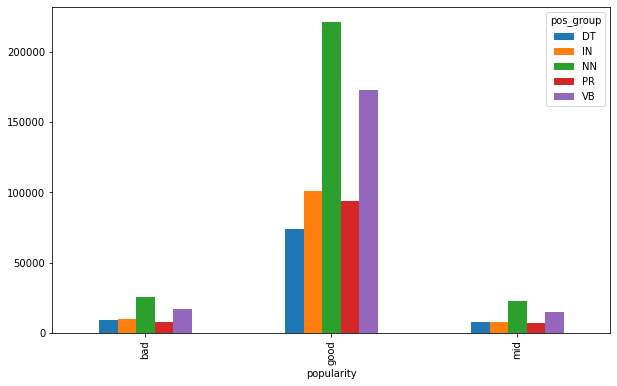

In [400]:
pivot_v1_df.plot(kind='bar', figsize=(10, 6))

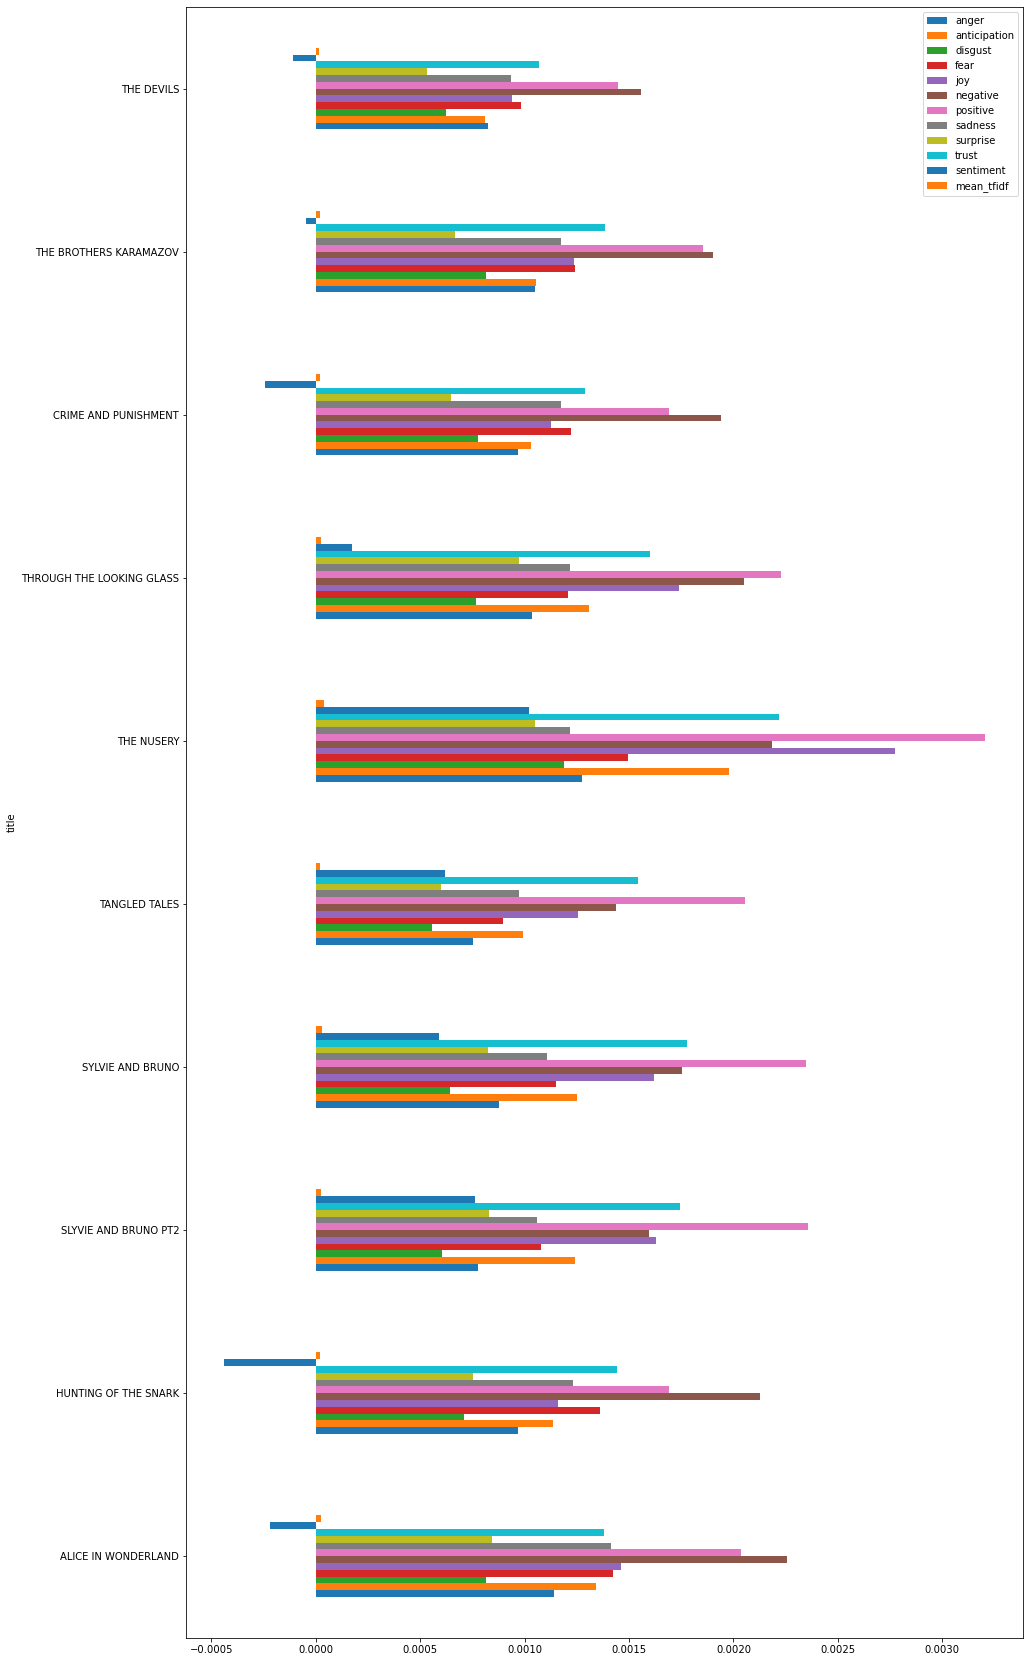

In [236]:
EMO_BOOKS.plot.barh(figsize=(15,30));

In [ ]:
# visulization #2: line plots of various sentiments in each book

In [406]:
cp_chaps = emo_chaps.loc[emo_chaps['book_id'] == 8]
cp_chaps.set_index(['book_id', 'chap_id'], inplace=True)

In [412]:
cp_chaps_thin= EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(8))

In [413]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

In [416]:
px.line(cp_chaps_thin, x='chap_id', y='value', color='emo')

In [ ]:
# visualization #3: barplot of emotional words and POS

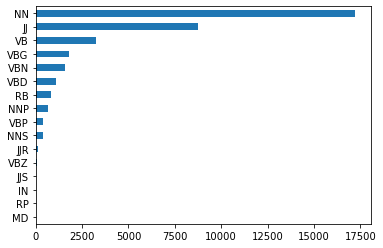

In [417]:
B.max_pos.value_counts().sort_values().plot.barh();

In [ ]:
# visualization #3: sentiment vs popularity

#### og code

In [ ]:
# collapse TFIDF